# Basic DMDB Analysis

In [6]:
import pandas as pd
import networkx as nx
import re
import yaml
from itertools import chain
from pathlib import Path
from operator import itemgetter
from collections import defaultdict

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#Import data_tools module 
import sys
sys.path.insert(0, '/home/agonzalez/data_tools/')

from data_tools.files import download
#from path_plots.dmdb_plots import plot_path
from data_tools.plotting import count_plot_h, venn2_pretty, venn3_pretty

from pySankey.sankey import sankey


In [11]:
# Make the output folders
this_name = '1_basic_dmdb_analysis'
out_dir = Path('../2_pipeline').joinpath(this_name, 'out').resolve()
out_dir.mkdir(parents=True, exist_ok=True)

data_dir = Path('../0_data/external').resolve()
data_dir.mkdir(parents=True, exist_ok=True)

In [12]:
#DONT RUN THIS AGAIN. LAST TIME IT WAS SAVED: APRIL 11 2022
#DMDB_URL = 'https://raw.githubusercontent.com/SuLab/DrugMechDB/main/indication_paths.yaml'
#download(DMDB_URL, data_dir.joinpath('indication_paths.yaml'), redownload=False)

In [13]:
with open(data_dir.joinpath('indication_paths.yaml'), 'r') as fh:
        ind = yaml.safe_load(fh)

In [14]:
def path_to_tup(path):
    return (path['graph']['drugbank'], path['graph']['disease_mesh'])

def path_to_G(path):
    return nx.node_link_graph(path)                                                                                        

def get_all_paths(path):
    source_id = path['links'][0]['source']                                                                              
    target_ids = list(set([l['target'] for l in path['links']]) - set([l['source'] for l in path['links']]))
    G = path_to_G(path)
    this_paths = list(chain(*[list(nx.all_simple_paths(G, source_id, target_id)) for target_id in target_ids]))         
    return this_paths

def get_id_to_type(G):
    id_to_type = {}
    for n in G.nodes.data():
        id_to_type[n[0]] = n[1]['label']
    return id_to_type

def get_id_to_name(G):
    id_to_name = {}
    for n in G.nodes.data():
        id_to_name[n[0]] = n[1]['name']
    return id_to_name

def add_metaedges(G):
    id_to_type = get_id_to_type(G)
    for e in G.edges:
        G.edges[e]['metaedge'] = id_to_type[e[0]] + ' - ' + e[2] + ' - ' + id_to_type[e[1]]
    return G

def add_meanode_pairs(G):
    id_to_type = get_id_to_type(G)
    for e in G.edges:
        G.edges[e]['mn_pair'] = id_to_type[e[0]] + ' - ' + id_to_type[e[1]]
    return G

def get_targets(G):
    drug = list(G.edges)[0][0]
    targets = []
    for e in G.edges:
        if e[0] == drug:
            targets.append(e[1])
    return targets

def get_target_metaedges(G):
    drug = list(G.edges)[0][0]
    target_mes = []
    if 'metaedge' not in G.edges[list(G.edges)[0]]:
        G = add_metaedges(G)
    
    for e in G.edges:
        if e[0] == drug:
            target_mes.append(G.edges[e]['metaedge'])
    return target_mes

### Things we'll explore in this notebook

-  Number of paths
-  Longest Path
-  Shortest path
-  Number of nodes
-  Number of edges

- most common metaedge
- most common pairing
- most common node
- common targets
- First edge type

In [15]:
basic_stats1 = defaultdict(list)
all_metaedges = []
all_parings = []
all_targets = []
unique_metaedges = []
first_edge_type = []
all_nodes = []

id_to_name = {}
id_to_label = {}

for i, p in enumerate(ind):
    drug_id, dis_id = path_to_tup(p)
    paths = get_all_paths(p)
    G = path_to_G(p)
    
    G = add_metaedges(G)
    G = add_meanode_pairs(G)
    
    basic_stats1['idx'].append(i)
    basic_stats1['id'].append(p['graph']['_id'])
    basic_stats1['drug'].append(drug_id)
    basic_stats1['disease'].append(dis_id)
    basic_stats1['n_nodes'].append(len(G.nodes))
    basic_stats1['n_edges'].append(len(G.edges))
    basic_stats1['n_paths'].append(len(paths))
    basic_stats1['longest_path'].append(max([len(p) for p in paths]))
    basic_stats1['shortest_path'].append(max([len(p) for p in paths]))
    basic_stats1['metapath'].append(" - ".join([n[1]['label'] for n in G.nodes.data()]))
    basic_stats1['metapath_with_edges'].append("".join([re.sub(" - [^-]*$"," - ",e[2]['metaedge']) for e in G.edges.data()])+"Disease")

    
    this_metaedges = [G.edges[e]['metaedge'] for e in G.edges]
    
    all_metaedges += this_metaedges
    unique_metaedges += list(set(this_metaedges))
    
    all_parings += [G.edges[e]['mn_pair'] for e in G.edges]
    all_targets += get_targets(G)
    first_edge_type += get_target_metaedges(G)
    all_nodes += list(G.nodes)
    
    id_to_label = {**id_to_label, **get_id_to_type(G)}
    id_to_name = {**id_to_name, **get_id_to_name(G)}
    
basic_stats1 = pd.DataFrame(basic_stats1)

In [ ]:
basic_stats1.head()

In [17]:
#lets take an example
basic_stats1[basic_stats1["id"]=="DB00316_MESH_D010146_1"]["metapath"].iloc[0]

'Drug - Protein - Protein - Pathway - ChemicalSubstance - Disease'

In [18]:
basic_stats1[basic_stats1["id"]=="DB00316_MESH_D010146_1"]["metapath_with_edges"].iloc[0]

'Drug - decreases activity of - Drug - decreases activity of - Drug - negatively regulates - Protein - increases abundance of - Protein - increases abundance of - Pathway - affects risk for - ChemicalSubstance - causes - Disease'

🍄 Lets get metapaths (only include nodes)

In [19]:

all_metapath_nodes = defaultdict(list)
for i, p in enumerate(ind):
    
    _id = (p["graph"]["_id"])
    
    drug_id, dis_id = path_to_tup(p)
    paths = get_all_paths(p)
    G = path_to_G(p)
    
    G = add_metaedges(G)
    G = add_meanode_pairs(G)
    
    this_metaedges = [G.edges[e]['metaedge'] for e in G.edges]
   
   
    
    #lets construct a graph for metapath
    graph = nx.DiGraph()
    for rel in this_metaedges:
        rel = rel.split(" - ")
        graph.add_edge(rel[0], rel[2], weight =rel[1]) #Add nodes and edges 
        
    edge_labels = nx.get_edge_attributes(graph,'weight') #set edge labels
    
    
    #get paths (nodes) and #add the edges     
   
    
    try: 
        st = 'Drug'  #start node
        end = 'Disease'  #end node
        for mp in nx.all_simple_paths(graph, st, end):
            mp_str = (" - ".join(mp))
            
            all_metapath_nodes[_id].append(mp_str)
            
        
    except:
        st = 'Disease'  #start node
        end = 'Drug'  #end node
        for mp in nx.all_simple_paths(graph, st, end):
            mp_str = (" - ".join(mp))
            all_metapath_nodes[_id].append(mp_str)

🍄 Lets first get the metapaths + edges

In [21]:

all_metapath_edges = defaultdict(list)
for i, p in enumerate(ind):
    _id = (p["graph"]["_id"])
    drug_id, dis_id = path_to_tup(p)
    paths = get_all_paths(p)
    G = path_to_G(p)
    
    G = add_metaedges(G)
    G = add_meanode_pairs(G)
    
    this_metaedges = [G.edges[e]['metaedge'] for e in G.edges]
   
   
    
    #lets construct a graph for metapath
    graph = nx.DiGraph()
    for rel in this_metaedges:
        rel = rel.split(" - ")
        graph.add_edge(rel[0], rel[2], weight =rel[1]) #Add nodes and edges 
        
    edge_labels = nx.get_edge_attributes(graph,'weight') #set edge labels
    
    
    #get paths (nodes) and #add the edges     
    try:
        st = 'Drug'  #start node
        end = 'Disease'  #end node
        meta_path=[]
        for mp in nx.all_simple_paths(graph, st, end):
            
            metaedge =[]

            #for value in mp 
            for n in range(len(mp)):
                if n == (len(mp)-1):
                    continue

                else:
                     result = (mp[n] + " - " + edge_labels.get((mp[n], (mp[n+1])))+ " - ")
                     metaedge.append(result)
            
            me = ("".join(metaedge)+ "Disease")
            all_metapath_edges[_id].append(me)

    except: 
        st = 'Disease'  #start node
        end = 'Drug'  #end node
        meta_path=[]
        for mp in nx.all_simple_paths(graph, st, end):
            
            metaedge =[]

            #for value in mp 
            for n in range(len(mp)):
                if n == (len(mp)-1):
                    continue

                else:
                     result = (mp[n] + " - " + edge_labels.get((mp[n], (mp[n+1])))+ " - ")
                     metaedge.append(result)
            
            me = ("".join(metaedge)+ "Drug")
            all_metapath_edges[_id].append(me)

Append all info together

In [24]:
basic_stats = defaultdict(list)
all_metaedges = []
all_parings = []
all_targets = []
unique_metaedges = []
first_edge_type = []
all_nodes = []

id_to_name = {}
id_to_label = {}

for i, p in enumerate(ind):
    _id = (p["graph"]["_id"])
    drug_id, dis_id = path_to_tup(p)
    paths = get_all_paths(p)
    G = path_to_G(p)
    
    G = add_metaedges(G)
    G = add_meanode_pairs(G)
    
    basic_stats['idx'].append(i)
    basic_stats['id'].append(p['graph']['_id'])
    basic_stats['drug'].append(drug_id)
    basic_stats['disease'].append(dis_id)
    basic_stats['n_nodes'].append(len(G.nodes))
    basic_stats['n_edges'].append(len(G.edges))
    basic_stats['n_paths'].append(len(paths))
    basic_stats['longest_path'].append(max([len(p) for p in paths]))
    basic_stats['shortest_path'].append(max([len(p) for p in paths]))
    basic_stats['metapath'].append(all_metapath_nodes[_id])
    basic_stats['metapath_with_edges'].append(all_metapath_edges[_id])

    
    this_metaedges = [G.edges[e]['metaedge'] for e in G.edges]
    
    all_metaedges += this_metaedges
    unique_metaedges += list(set(this_metaedges))
    
    all_parings += [G.edges[e]['mn_pair'] for e in G.edges]
    all_targets += get_targets(G)
    first_edge_type += get_target_metaedges(G)
    all_nodes += list(G.nodes)
    
    id_to_label = {**id_to_label, **get_id_to_type(G)}
    id_to_name = {**id_to_name, **get_id_to_name(G)}
    
basic_stats = pd.DataFrame(basic_stats)

In [25]:
basic_stats

,idx,id,drug,disease,n_nodes,n_edges,n_paths,longest_path,shortest_path,metapath,metapath_with_edges
0,0,DB00619_MESH_D015464_1,DB:DB00619,MESH:D015464,3,2,1,3,3,[Drug - Protein - Disease],[Drug - decreases activity of - Protein - caus...
1,1,DB00619_MESH_D034721_1,DB:DB00619,MESH:D034721,5,5,2,4,4,[Drug - Protein - BiologicalProcess - Disease],[Drug - decreases activity of - Protein - posi...
2,2,DB00316_MESH_D010146_1,DB:DB00316,MESH:D010146,6,7,3,4,4,"[Drug - Protein - ChemicalSubstance - Disease,...",[Drug - decreases activity of - Protein - incr...
3,3,DB00316_MESH_D005334_1,DB:DB00316,MESH:D005334,5,4,1,5,5,[Drug - Pathway - GrossAnatomicalStructure - B...,[Drug - negatively regulates - Pathway - occur...
4,4,DB00945_MESH_D010146_1,DB:DB00945,MESH:D010146,5,5,2,4,4,[Drug - Protein - ChemicalSubstance - Disease],[Drug - decreases activity of - Protein - incr...
...,...,...,...,...,...,...,...,...,...,...,...
3733,3733,DB00618_MESH_D013203_1,DB:DB00618,MESH:D013203,7,7,2,6,6,[Drug - CellularComponent - BiologicalProcess ...,[Drug - decreases activity of - CellularCompon...
3734,3734,DB00618_MESH_D013587_1,DB:DB00618,MESH:D013587,7,7,2,6,6,[Drug - CellularComponent - BiologicalProcess ...,[Drug - decreases activity of - CellularCompon...
3735,3735,DB00618_MESH_D014141_1,DB:DB00618,MESH:D014141,7,7,2,6,6,[Drug - CellularComponent - BiologicalProcess ...,[Drug - decreases activity of - CellularCompon...
3736,3736,DB00618_MESH_D014552_1,DB:DB00618,MESH:D014552,7,7,2,6,6,[Drug - CellularComponent - BiologicalProcess ...,[Drug - decreases activity of - CellularCompon...


In [26]:
print("Number of unique drugs: " + str(len(set(basic_stats['drug']))))
print("Number of unique diseases: " + str(len(set(basic_stats['disease']))))
print("Number of unique drug-disease combinations: " + str(len(basic_stats.groupby(['drug','disease']).size())))


Number of unique drugs: 1525
Number of unique diseases: 677
Number of unique drug-disease combinations: 3467


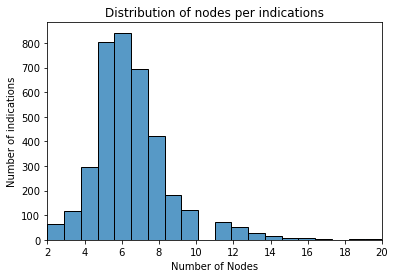

In [27]:
sns.histplot(basic_stats['n_nodes'],bins=20)
plt.xlim(2, 20)
plt.title('Distribution of nodes per indications')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of indications');

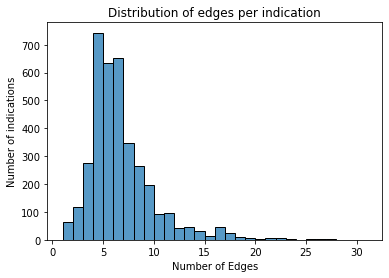

In [28]:
sns.histplot(basic_stats['n_edges'],binwidth=1)
plt.title('Distribution of edges per indication')
plt.xlabel('Number of Edges')
plt.ylabel('Number of indications');

In [29]:
max(basic_stats['n_paths'])

40

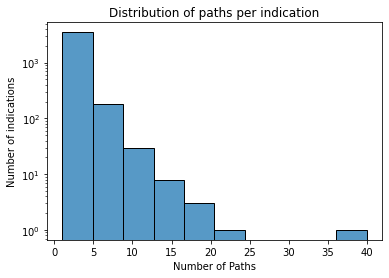

In [30]:
g = sns.histplot(basic_stats['n_paths'],bins=10)
g.set_yscale('log')
plt.title('Distribution of paths per indication')
plt.xlabel('Number of Paths')
plt.ylabel('Number of indications');

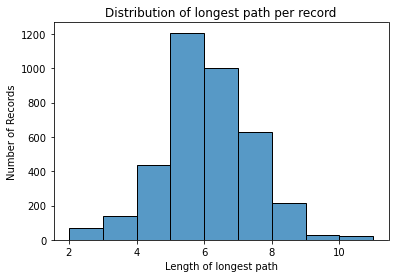

In [31]:
sns.histplot(basic_stats['longest_path'],binwidth=1)
plt.title('Distribution of longest path per record')
plt.xlabel('Length of longest path')
plt.ylabel('Number of Records');

#### Metanode parings

In [32]:
pair_counts = pd.Series(all_parings).value_counts()
pair_counts

Drug - Protein                           3650
Protein - BiologicalProcess              2548
BiologicalProcess - Disease              1862
BiologicalProcess - BiologicalProcess    1805
PhenotypicFeature - Disease               960
                                         ... 
Cell - OrganismTaxon                        1
Disease - GeneFamily                        1
PhenotypicFeature - Protein                 1
OrganismTaxon - ChemicalSubstance           1
MacromolecularComplex - GeneFamily          1
Length: 140, dtype: int64

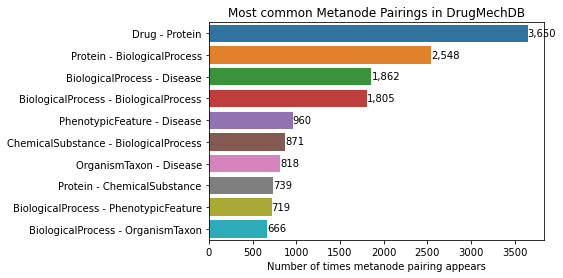

In [33]:
pair_counts = pd.Series(all_parings).value_counts()
count_plot_h(pair_counts.head(10))
plt.title('Most common Metanode Pairings in DrugMechDB')
plt.xlabel('Number of times metanode pairing appears');

In [34]:
pd.Series(all_parings).value_counts()

Drug - Protein                           3650
Protein - BiologicalProcess              2548
BiologicalProcess - Disease              1862
BiologicalProcess - BiologicalProcess    1805
PhenotypicFeature - Disease               960
                                         ... 
Cell - OrganismTaxon                        1
Disease - GeneFamily                        1
PhenotypicFeature - Protein                 1
OrganismTaxon - ChemicalSubstance           1
MacromolecularComplex - GeneFamily          1
Length: 140, dtype: int64

Heatmap to represent the number of relations that exist of all possible combinations

In [35]:
#Create df for pairs and count them 
all_parings_set = set(all_parings)

pairs_df = pd.DataFrame()
num_pairs_nodes =[]
source_node = []
target_node = []

for pair in all_parings_set:
    num_pairs = len([i for i in all_parings if i == pair])
    num_pairs_nodes.append(num_pairs)
    
    value = pair.split(" - ")
    source_node.append(value[0])
    target_node.append(value[1])
        
pairs_df["source_node"]=source_node
pairs_df["target_node"]=target_node
pairs_df["count"]=num_pairs_nodes

In [36]:
pairs_df_hm =pairs_df.pivot("source_node", "target_node", "count")
pairs_df_hm= pairs_df_hm.fillna(0)

In [37]:
pairs_df_hm

target_node,BiologicalProcess,Cell,CellularComponent,ChemicalSubstance,Disease,Drug,GeneFamily,GrossAnatomicalStructure,MacromolecularComplex,MolecularActivity,OrganismTaxon,Pathway,PhenotypicFeature,Protein
source_node,,,,,,,,,,,,,,
BiologicalProcess,1805.0,158.0,111.0,485.0,1862.0,17.0,8.0,203.0,2.0,6.0,666.0,26.0,719.0,48.0
Cell,74.0,0.0,0.0,5.0,110.0,2.0,0.0,4.0,0.0,0.0,1.0,0.0,5.0,3.0
CellularComponent,105.0,3.0,48.0,4.0,18.0,0.0,2.0,6.0,0.0,17.0,138.0,0.0,10.0,16.0
ChemicalSubstance,871.0,19.0,90.0,82.0,407.0,6.0,80.0,79.0,3.0,11.0,39.0,7.0,169.0,258.0
Disease,7.0,0.0,0.0,2.0,111.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,5.0,14.0
Drug,349.0,8.0,87.0,628.0,70.0,46.0,560.0,23.0,13.0,53.0,23.0,19.0,18.0,3650.0
GeneFamily,527.0,3.0,7.0,71.0,35.0,0.0,13.0,5.0,0.0,45.0,4.0,19.0,15.0,32.0
GrossAnatomicalStructure,111.0,0.0,3.0,8.0,173.0,0.0,4.0,58.0,0.0,3.0,0.0,2.0,91.0,4.0
MacromolecularComplex,18.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


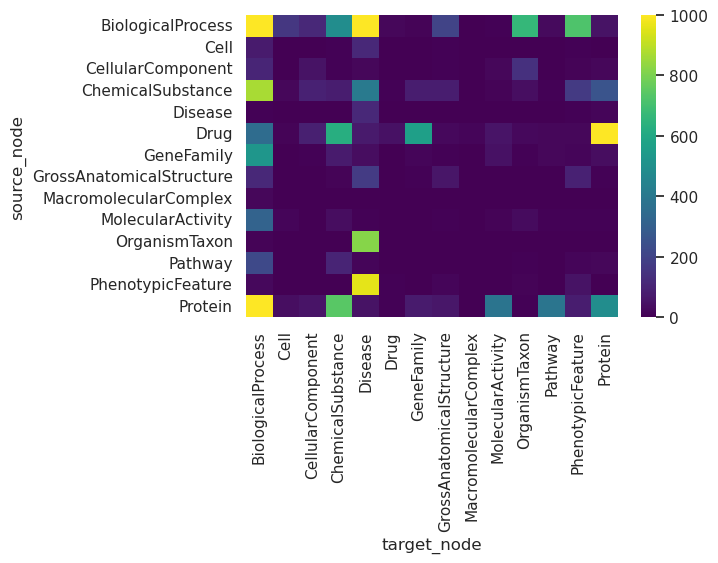

In [38]:
sns.set(rc={"figure.dpi":100})
ax = sns.heatmap(pairs_df_hm, cmap= "viridis", vmin = 0, vmax = 1000)

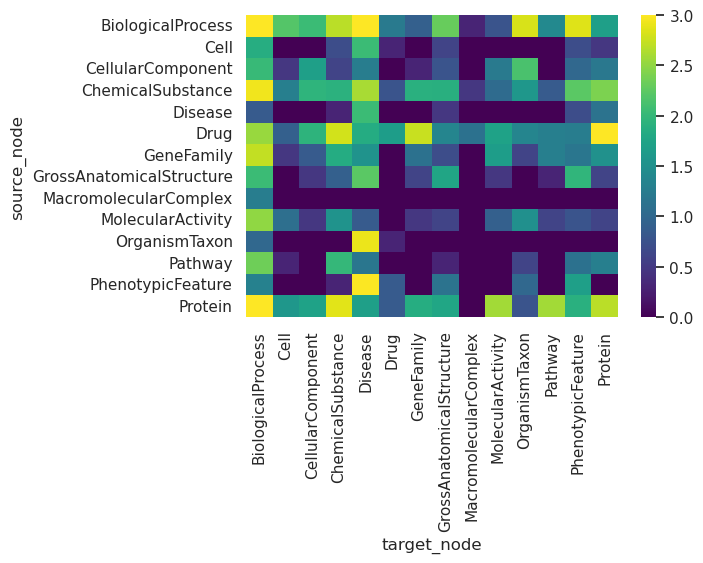

In [39]:
#Same heatmap using log scale
sns.set(rc={"figure.dpi":100})
ax = sns.heatmap(np.log10(pairs_df_hm+1e-10), cmap= "viridis", vmin = 0, vmax = 3)

In [40]:
source =[]
target =[]

for val in all_parings:
    val = val.split(" - ")
    source.append(val[0])
    target.append(val[1])
    

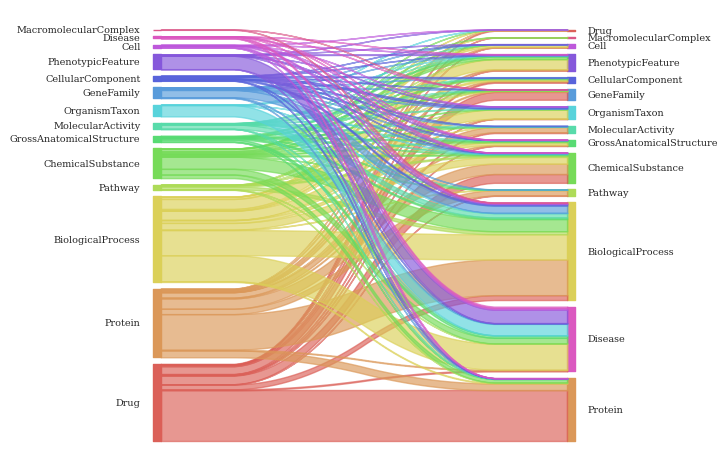

In [43]:


sankey(source, target, aspect=15, fontsize=7)
# Get current figure
fig = plt.gcf()

# Set size in inches
fig.set_size_inches(6, 6)

# Set the color of the background to white
fig.set_facecolor("w")

# Save the figure
#fig.savefig("DMDB_relations_sankey.png", bbox_inches="tight", dpi=500)

#### Metaedge use

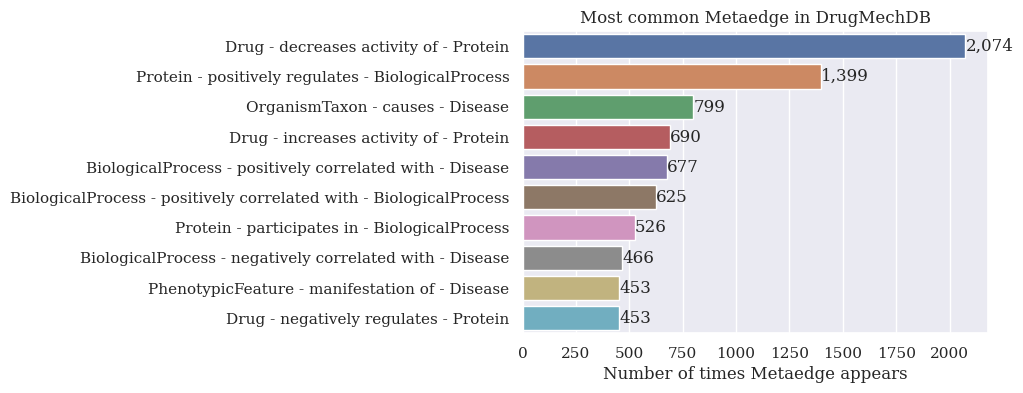

In [44]:
me_counts = pd.Series(all_metaedges).value_counts()
count_plot_h(me_counts.head(10))
plt.title('Most common Metaedge in DrugMechDB')
plt.xlabel('Number of times Metaedge appears');

#### Metaedges per record

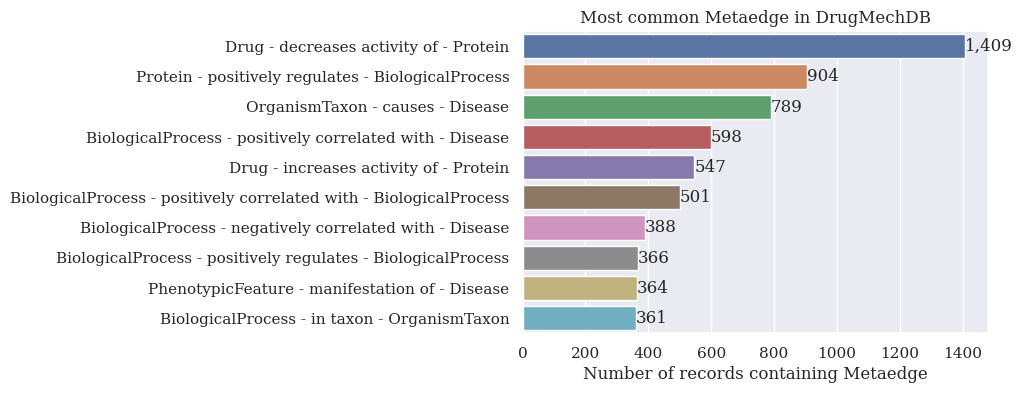

In [45]:
#Unique metaedges
ume_counts = pd.Series(unique_metaedges).value_counts()
count_plot_h(ume_counts.head(10))
plt.title('Most common Metaedge in DrugMechDB')
plt.xlabel('Number of records containing Metaedge');

In [46]:
len(set(unique_metaedges))

870

#### Metapaths

Only nodes

In [47]:
mp_nodes = []
for id_ in all_metapath_nodes:
    for p in all_metapath_nodes[id_]:
        mp_nodes.append(p)
freq_mp = dict((x,mp_nodes.count(x)) for x in set(mp_nodes))
freq_mp_sort = sorted(freq_mp.items(), key=lambda x: x[1],reverse = True)    

mp_nodes_df = pd.DataFrame()
mp_list = []
mp_count = []

for mp in freq_mp_sort:
    mp_list.append(mp[0])
    mp_count.append(mp[1])

mp_nodes_df["meta_path"] = mp_list
mp_nodes_df["count"] = mp_count

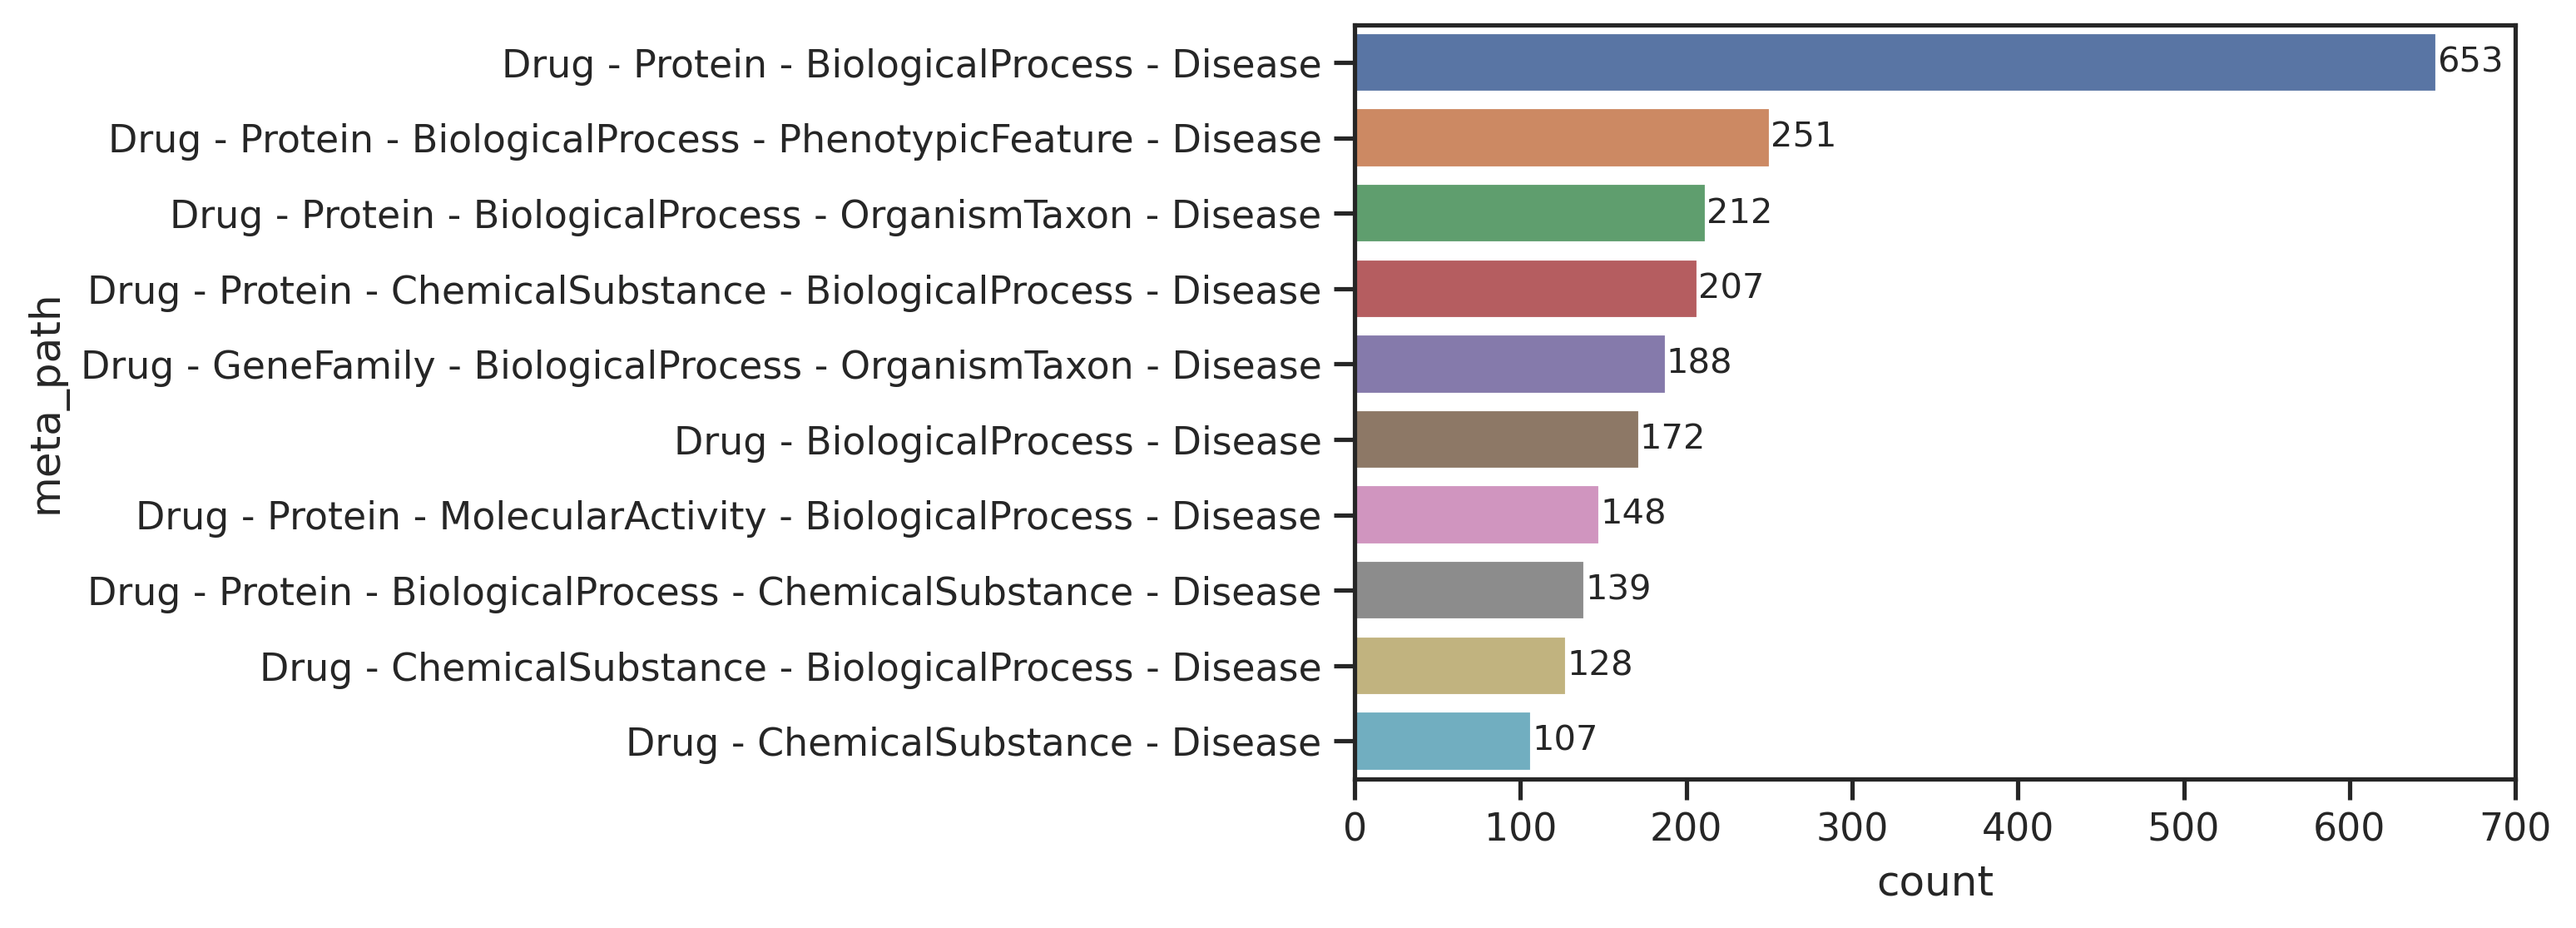

In [48]:

sns.set(rc={"figure.dpi":300})
sns.set_style("ticks") 
g = sns.barplot(x="count", y="meta_path", data=mp_nodes_df.head(10), orient = "h")
g.set_xlim(0,700)

for container in g.containers:
    g.bar_label(container,size= 10)

In [49]:
#Number of metapaths
len(set(mp_nodes))

313

With edges

In [50]:
mp_edges = []
for id_ in all_metapath_edges:
    for p in all_metapath_edges[id_]:
        mp_edges.append(p)
freq_mp = dict((x,mp_edges.count(x)) for x in set(mp_edges))
freq_mp_sort = sorted(freq_mp.items(), key=lambda x: x[1],reverse = True)    


mp_nodes_edges_df = pd.DataFrame()
mp_list = []
mp_count = []

for mp in freq_mp_sort:
    mp_list.append(mp[0])
    mp_count.append(mp[1])

mp_nodes_edges_df["meta_path-edges"] = mp_list
mp_nodes_edges_df["count"] = mp_count

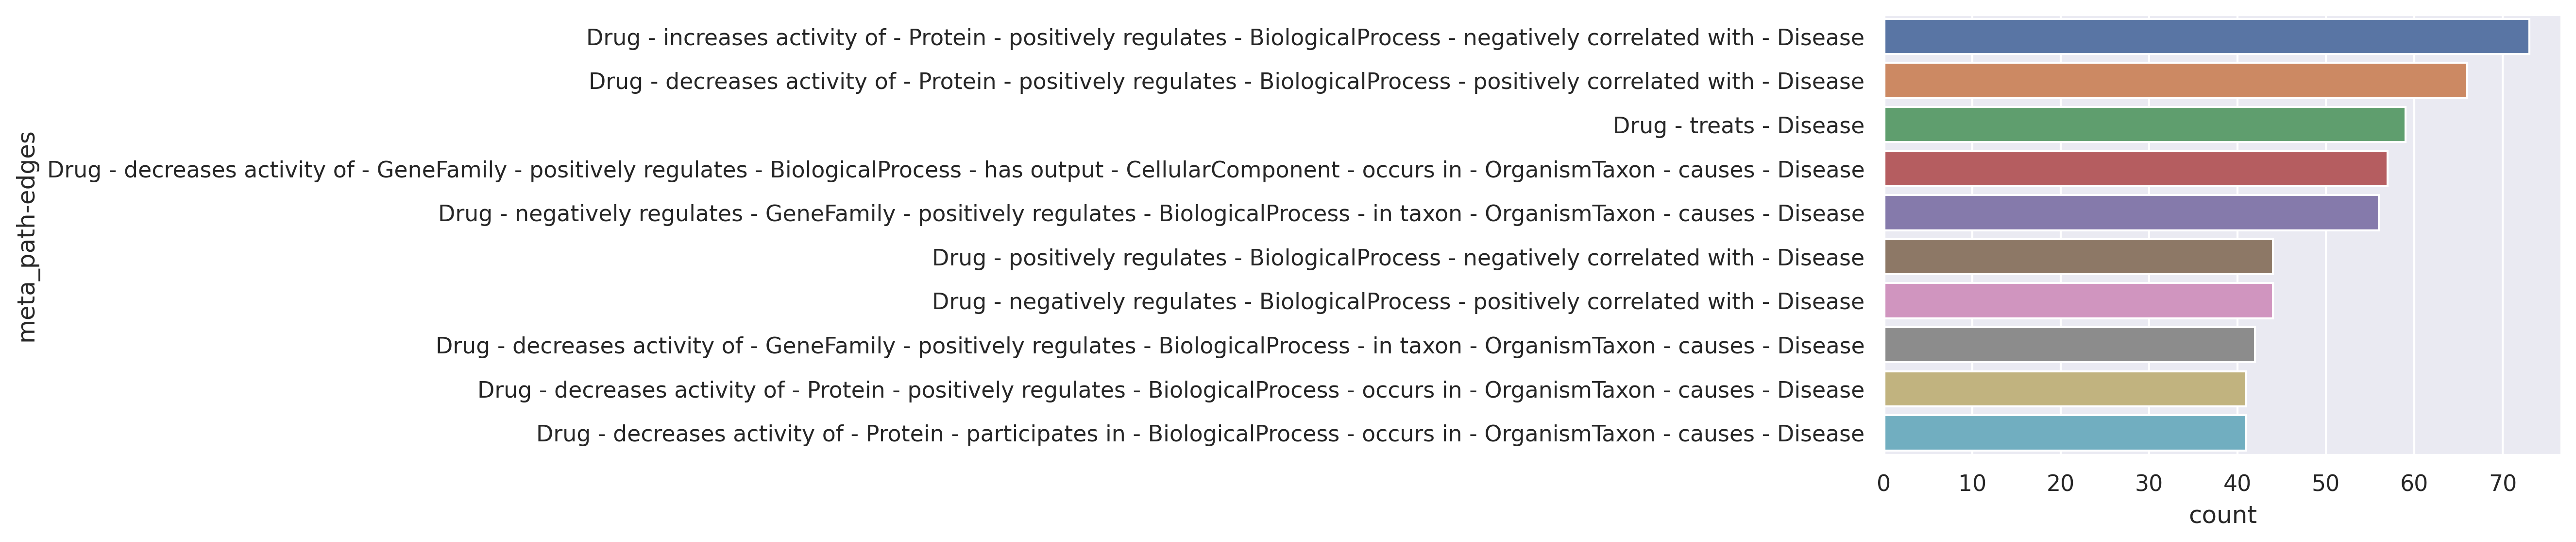

In [51]:
sns.set(rc={"figure.dpi":300})
sns.barplot(x="count", y="meta_path-edges", data=mp_nodes_edges_df.head(10), orient = "h")
sns.set_style("white") 

In [52]:
#number of meta_paths (with edges)
len(set(mp_edges))

1500

## Node information

In [53]:
node_counts = pd.Series(all_nodes, name='id')
node_counts = node_counts.to_frame().reset_index()
node_counts['name'] = node_counts['id'].map(id_to_name)
node_counts['label'] = node_counts['id'].map(id_to_label)

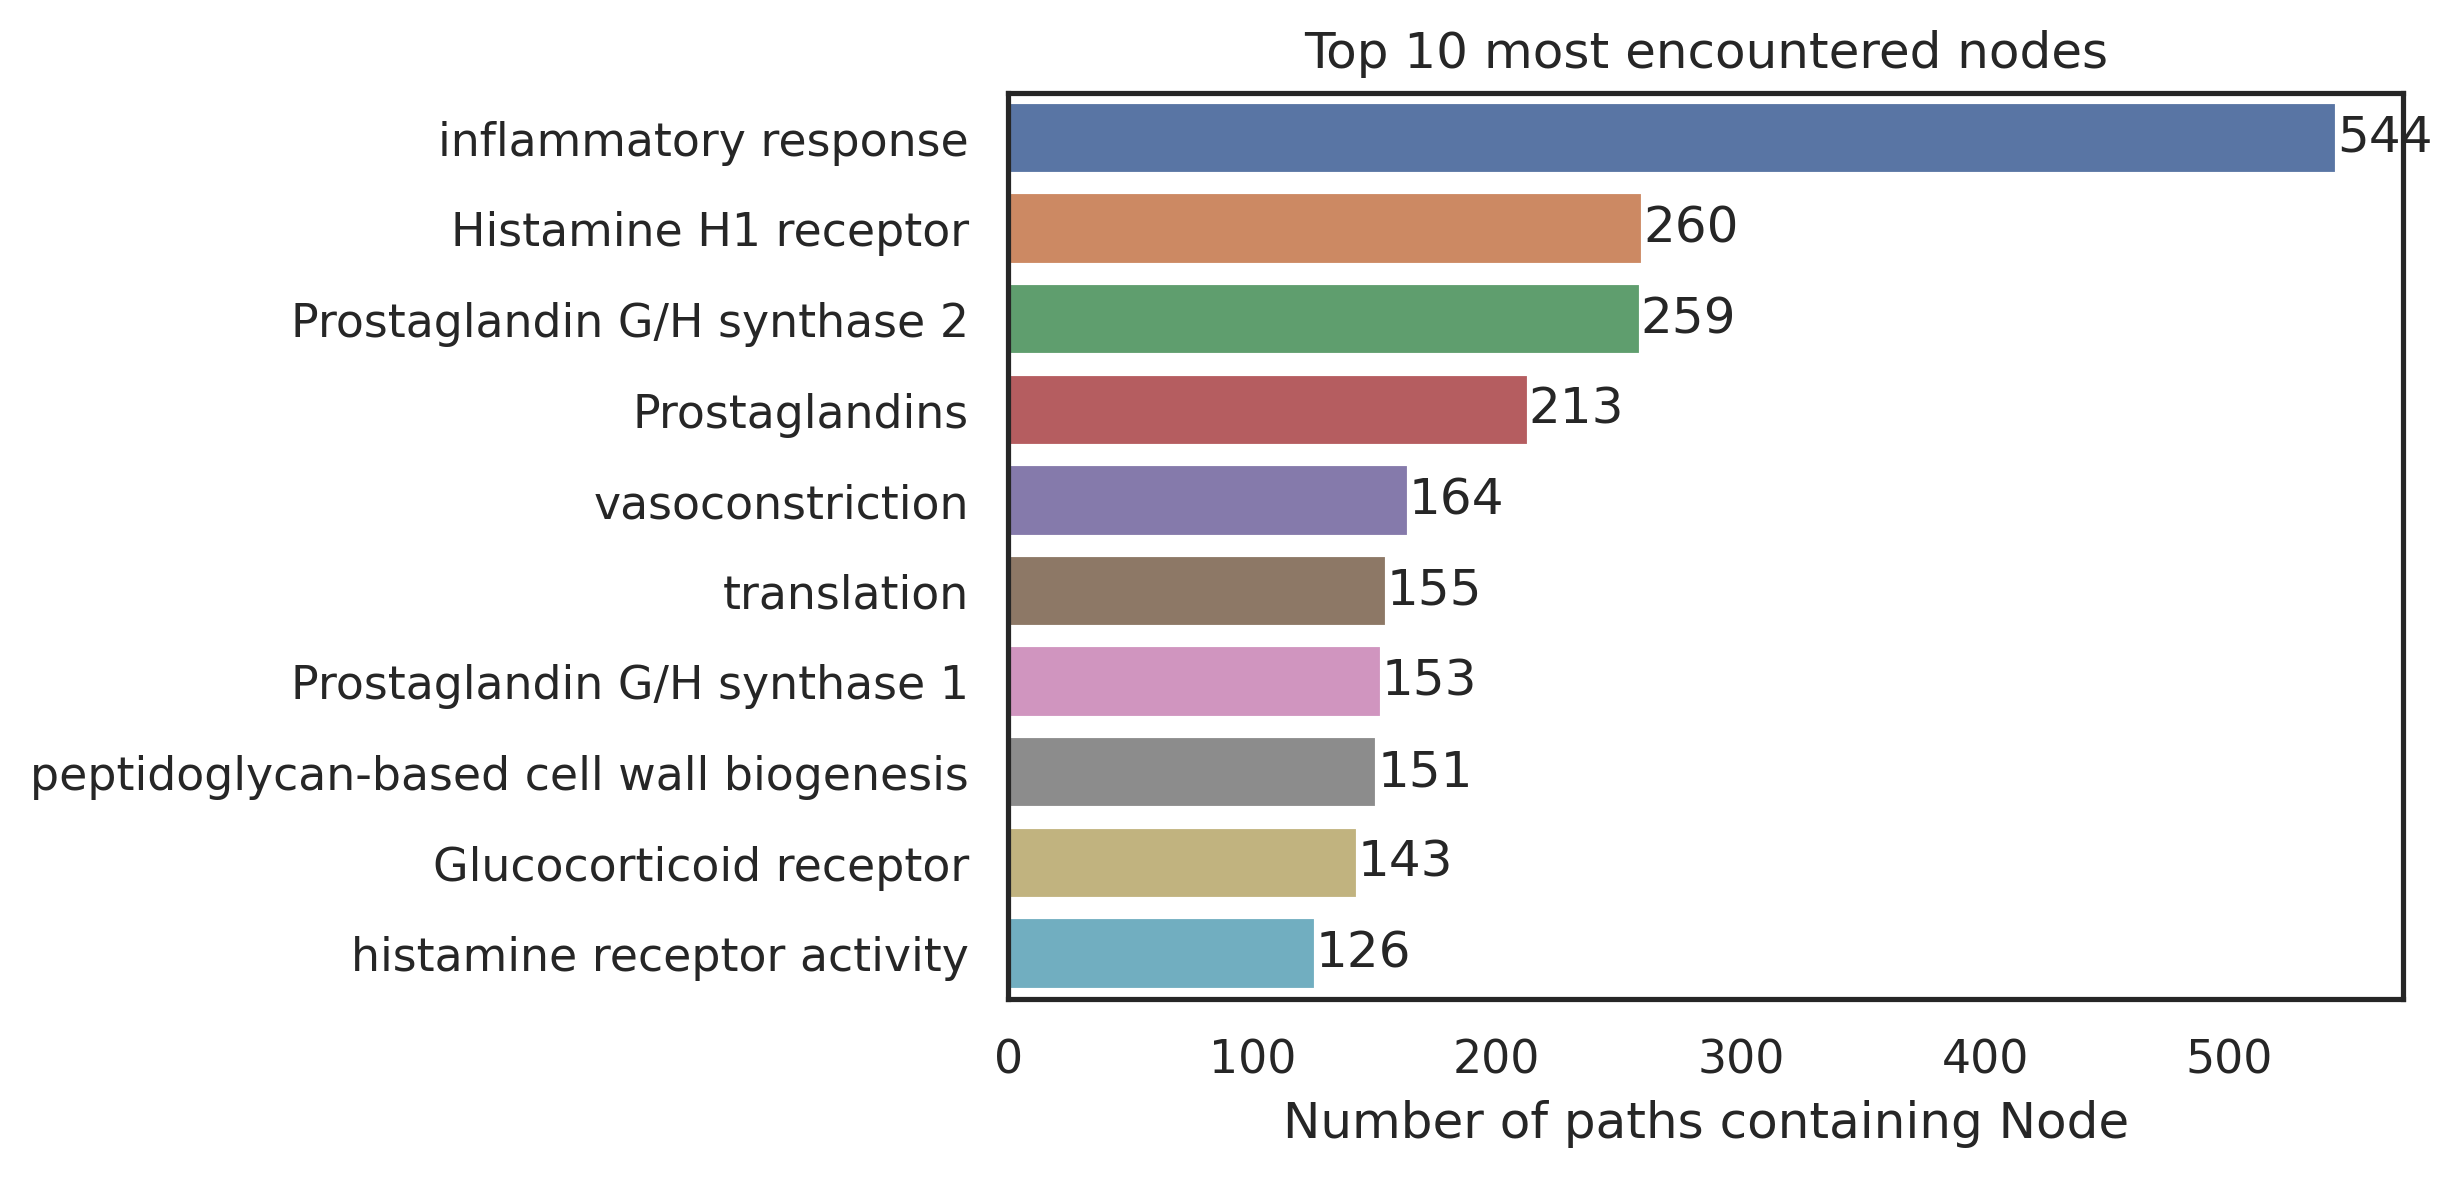

In [54]:
count_plot_h(node_counts['name'].value_counts().head(10))
plt.title('Top 10 most encountered nodes')
plt.xlabel('Number of paths containing Node')
plt.ylabel('');

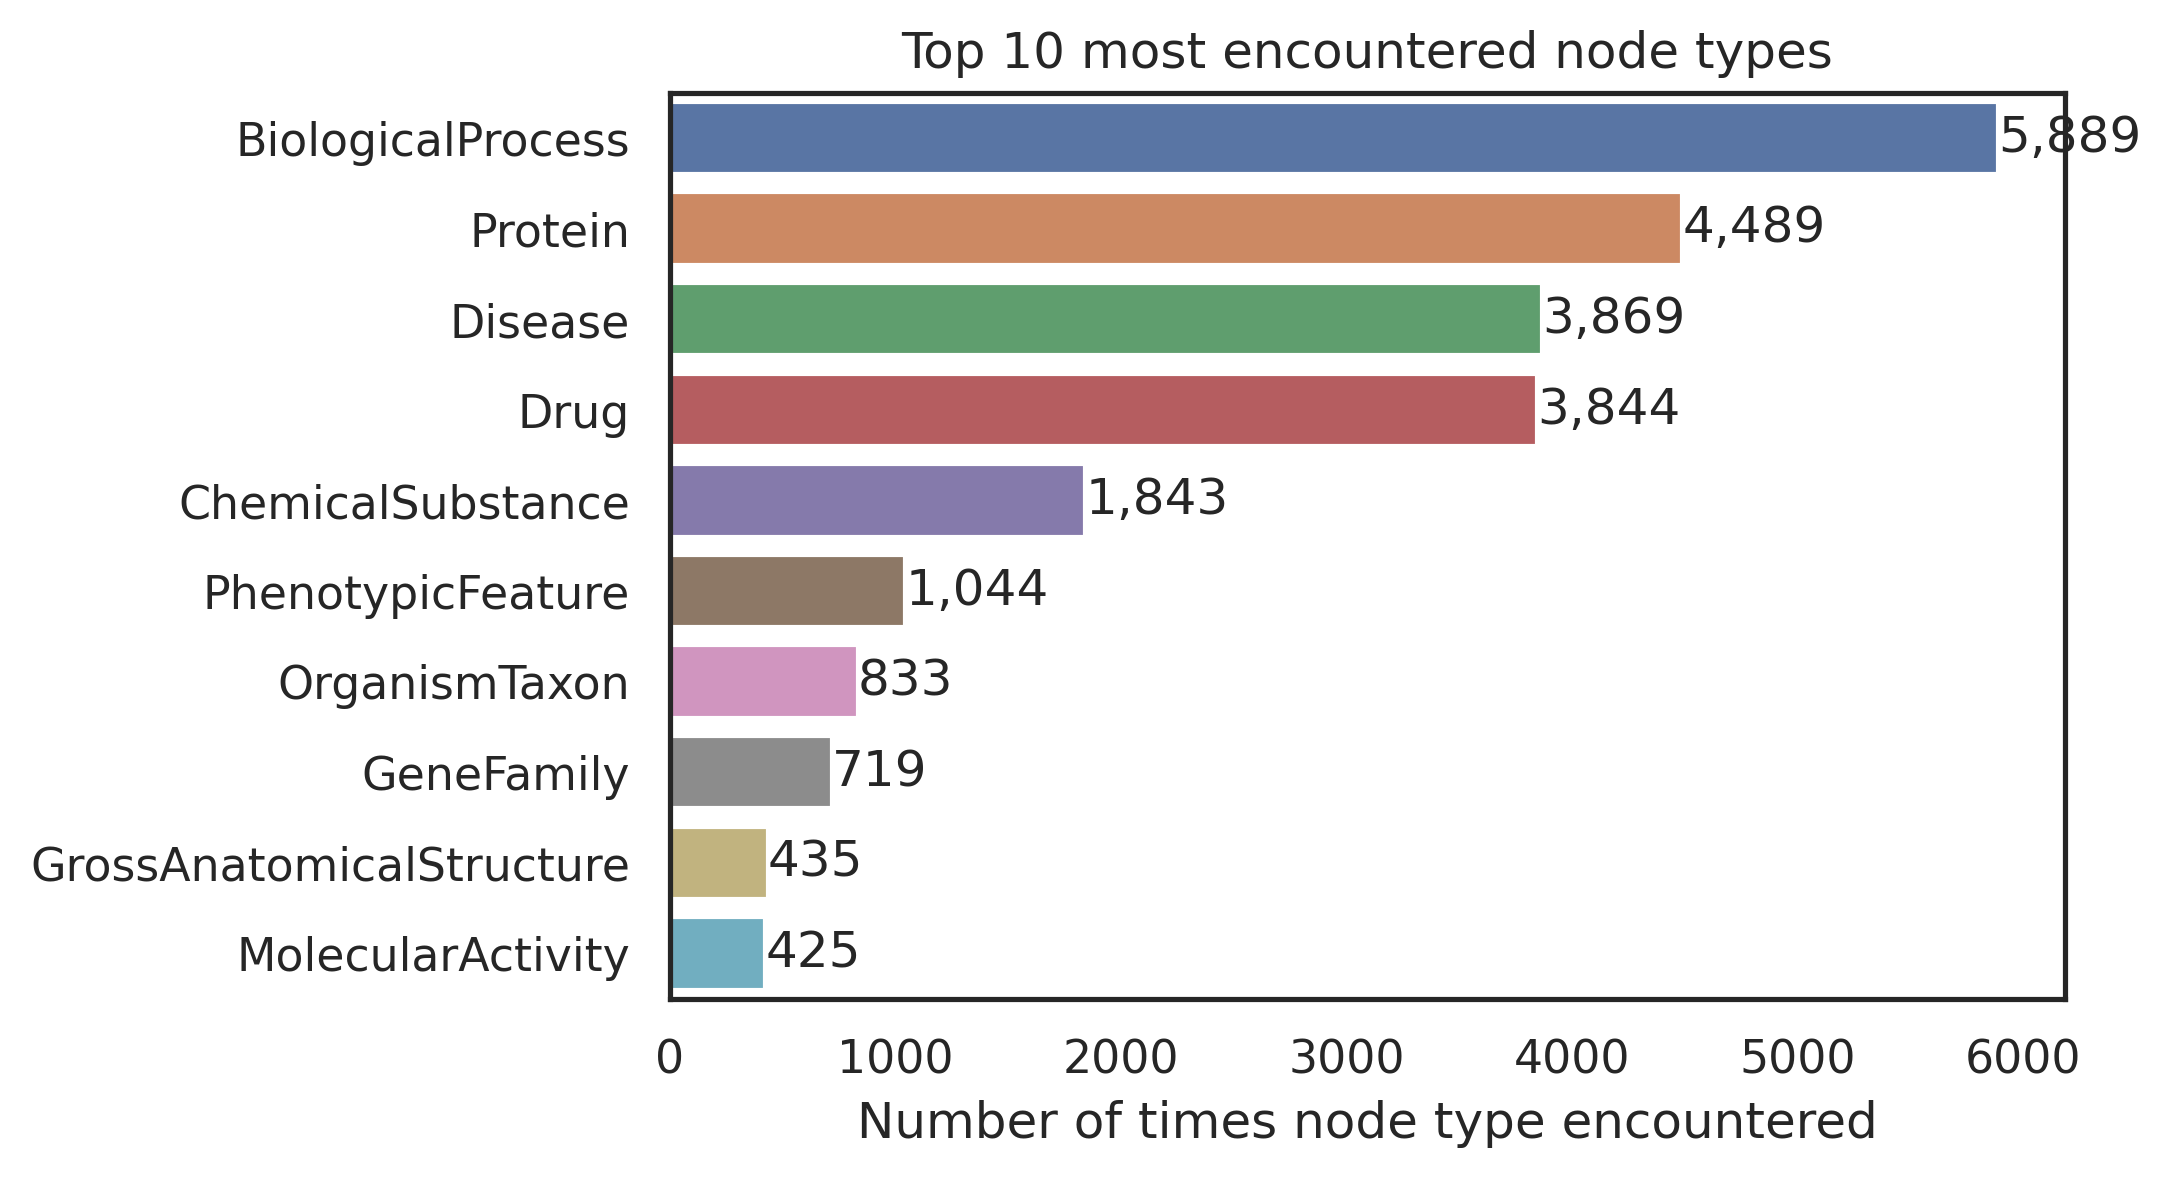

In [55]:
count_plot_h(node_counts['label'].value_counts().head(10))
plt.title('Top 10 most encountered node types')
plt.xlabel('Number of times node type encountered')
plt.ylabel('');

## Target Information

In [56]:
target_counts = pd.Series(all_targets, name='count')
target_counts = target_counts.value_counts().to_frame().reset_index().rename(columns={'index': 'id'})
target_counts['name'] = target_counts['id'].map(id_to_name)
target_counts['label'] = target_counts['id'].map(id_to_label)

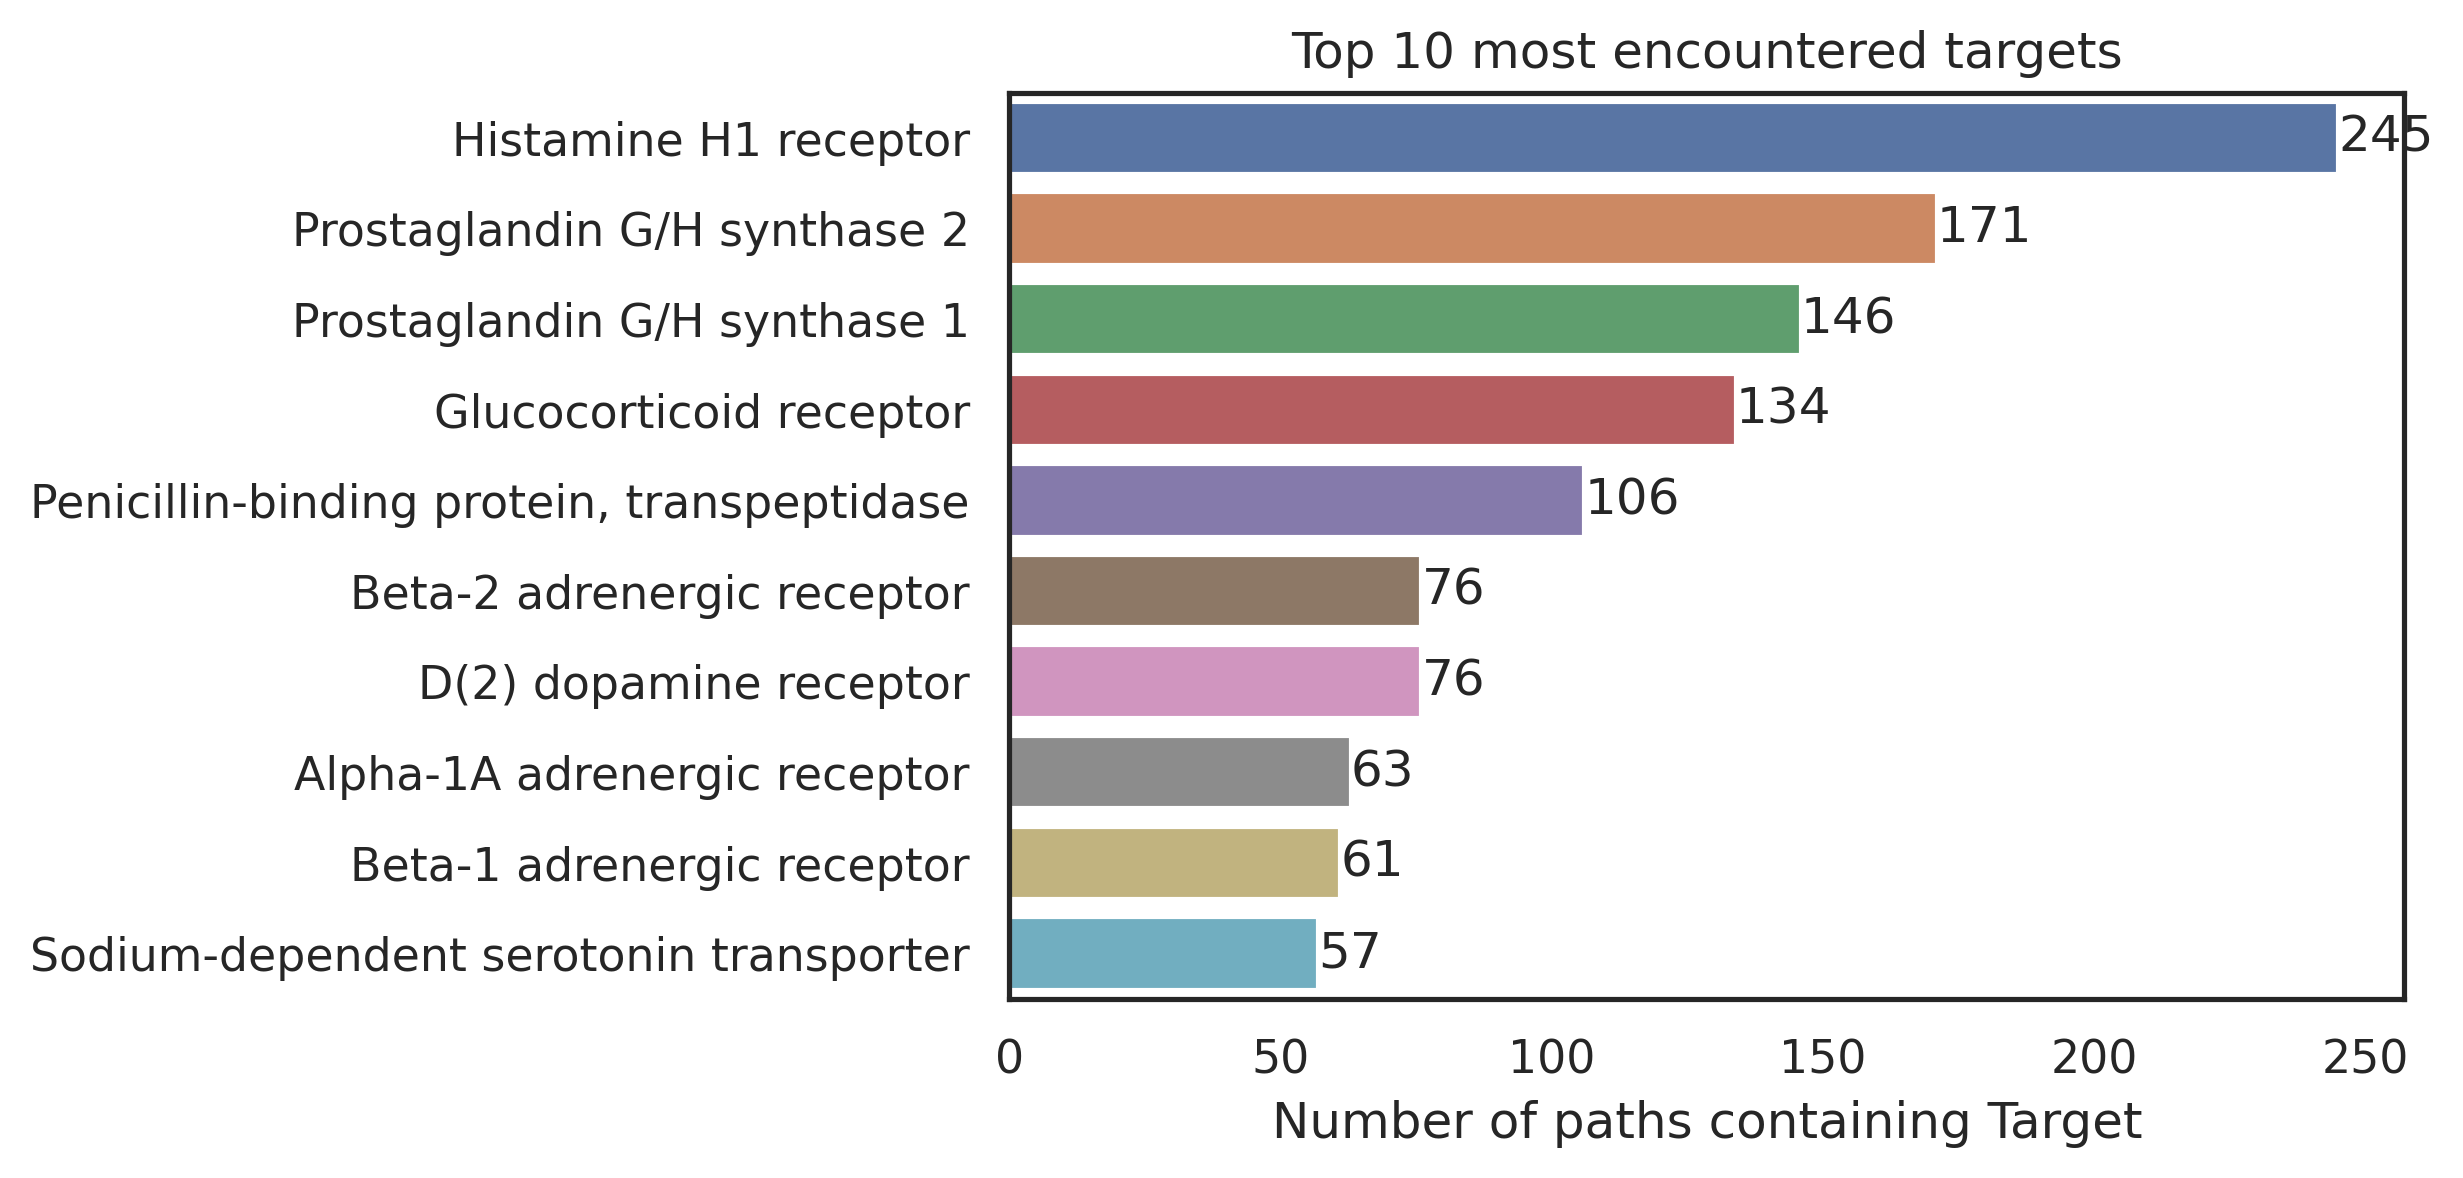

In [57]:
count_plot_h(target_counts.set_index('name').head(10)['count'])
plt.title('Top 10 most encountered targets')
plt.xlabel('Number of paths containing Target')
plt.ylabel('');

Evaluate what are the edges of first link. 

In [58]:
pd.Series(first_edge_type, name='type').to_frame()

,type
0,Drug - decreases activity of - Protein
1,Drug - decreases activity of - Protein
2,Drug - decreases activity of - Protein
3,Drug - decreases activity of - Protein
4,Drug - decreases activity of - Protein
...,...
5481,Drug - decreases activity of - CellularComponent
5482,Drug - decreases activity of - CellularComponent
5483,Drug - decreases activity of - CellularComponent
5484,Drug - decreases activity of - CellularComponent


In [59]:
fet_data = pd.Series(first_edge_type, name='type').to_frame()
fet_data['target_type'] = fet_data['type'].apply(lambda x: x.split(' - ')[2])
fet_data['interaction'] = fet_data['type'].apply(lambda x: x.split(' - ')[1])

In [60]:
fet_data.head()

,type,target_type,interaction
0,Drug - decreases activity of - Protein,Protein,decreases activity of
1,Drug - decreases activity of - Protein,Protein,decreases activity of
2,Drug - decreases activity of - Protein,Protein,decreases activity of
3,Drug - decreases activity of - Protein,Protein,decreases activity of
4,Drug - decreases activity of - Protein,Protein,decreases activity of


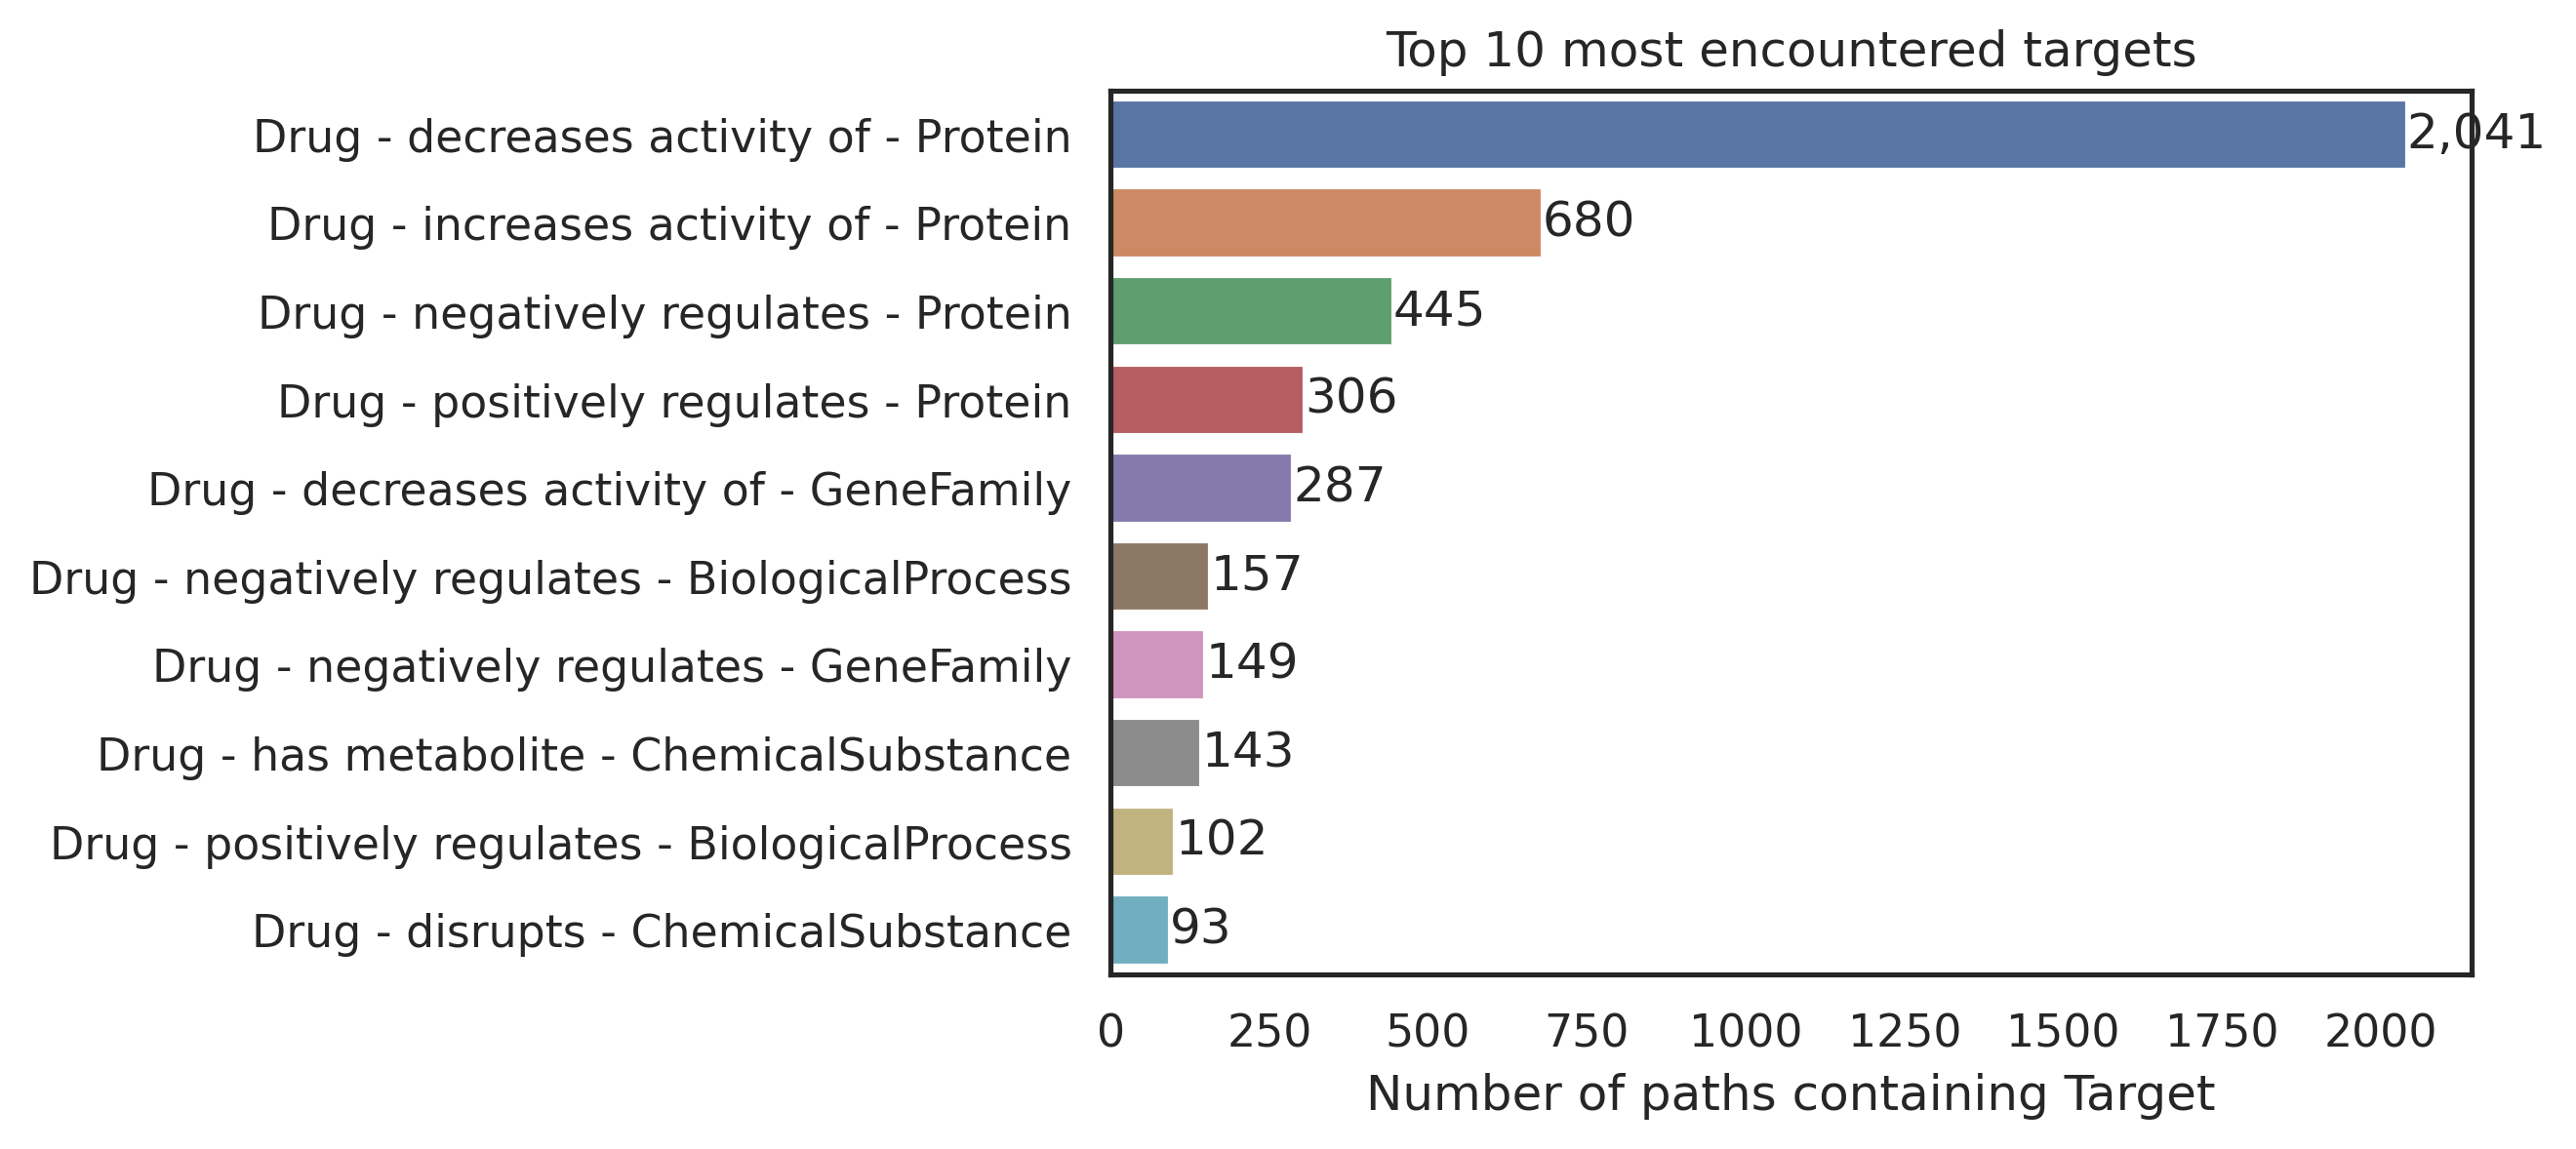

In [61]:
#Plot the top 10 most encountered edge types
count_plot_h(fet_data['type'].value_counts().head(10))
plt.title('Top 10 most encountered targets')
plt.xlabel('Number of paths containing Target')
plt.ylabel('');

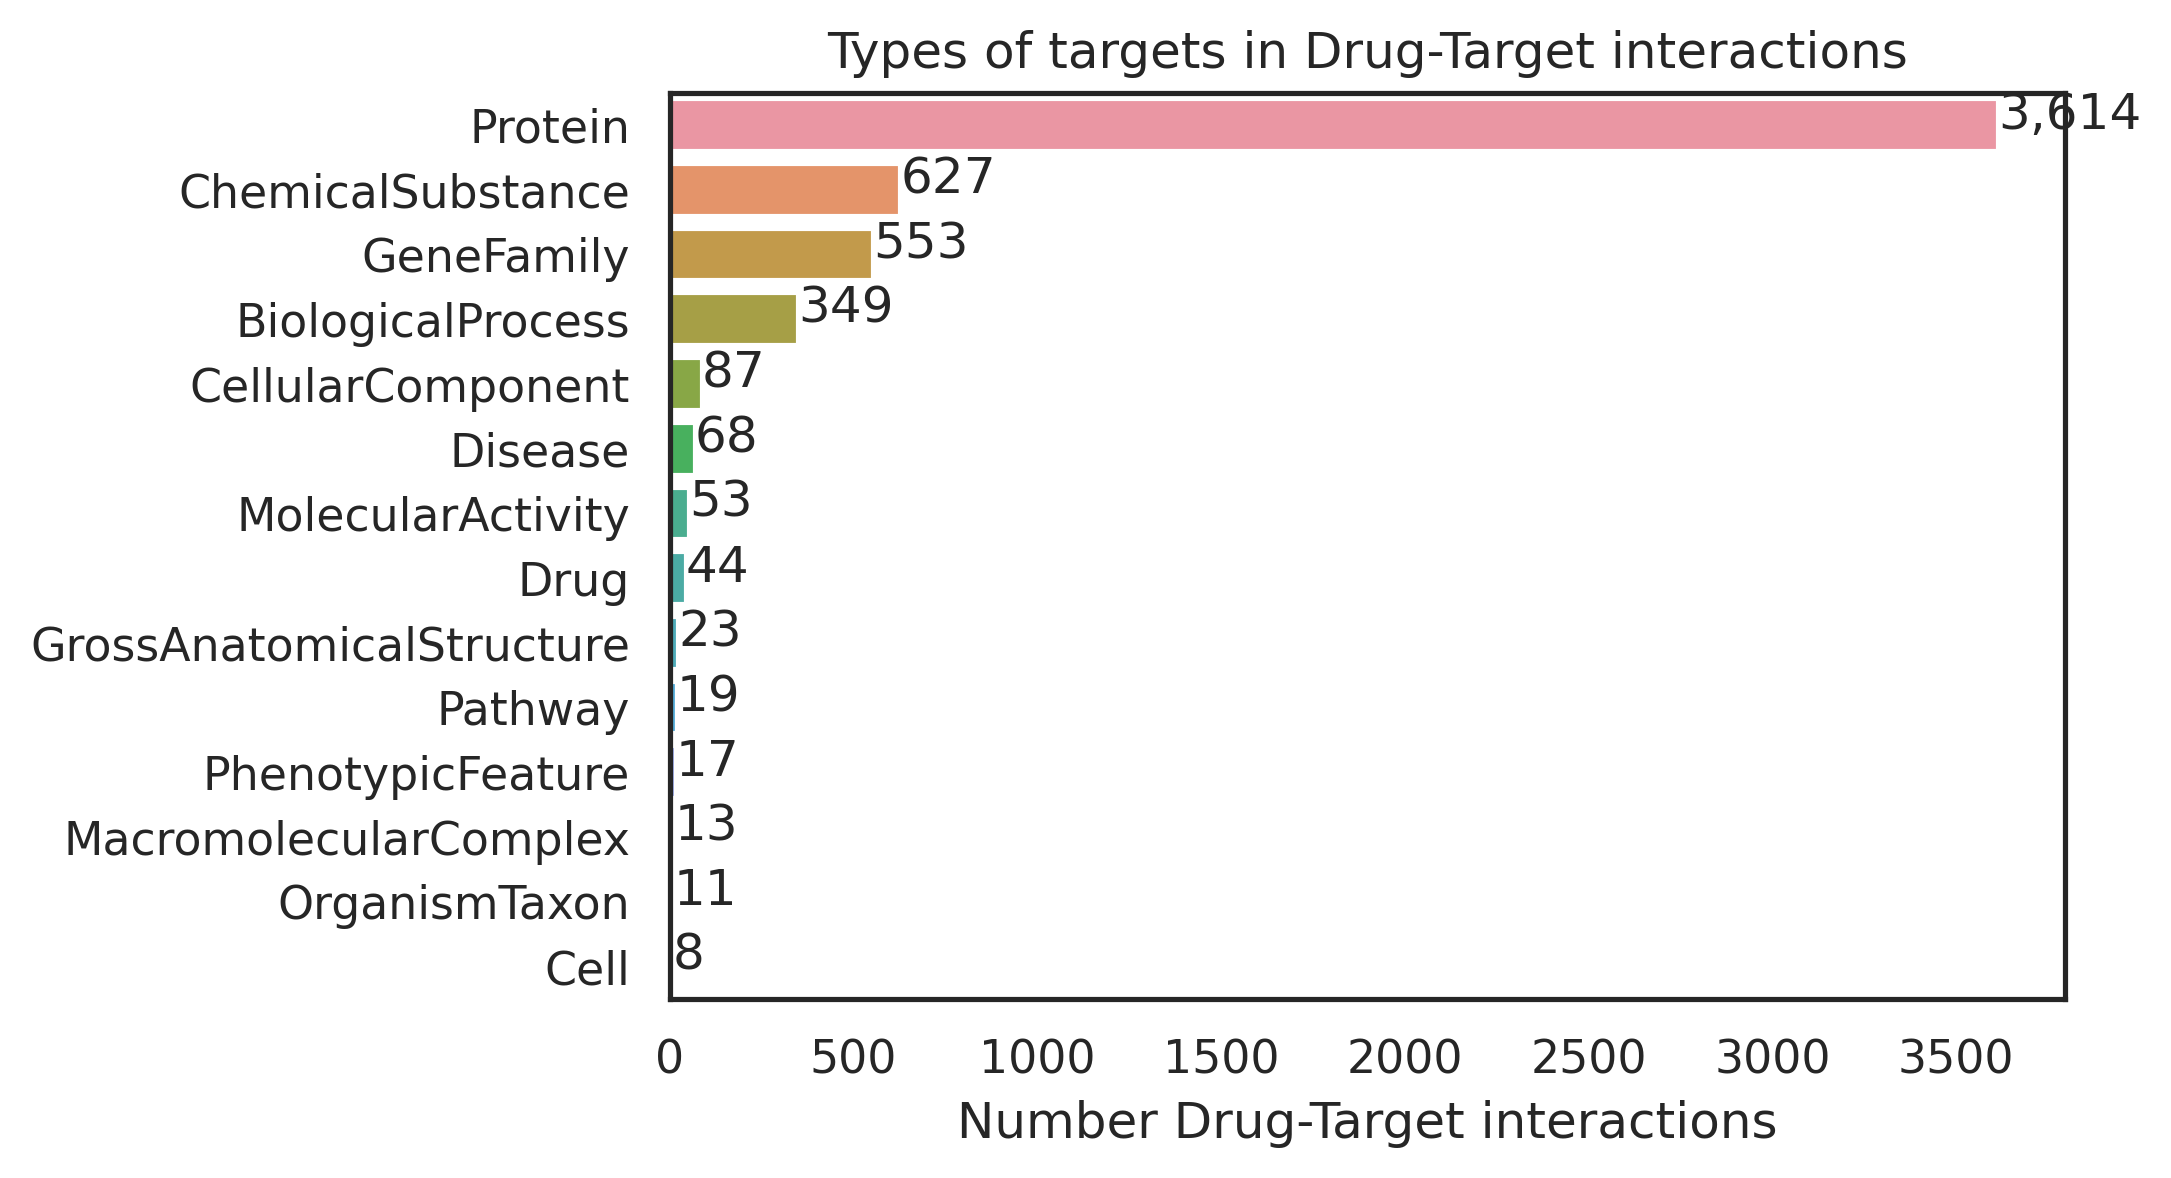

In [62]:
#Plot the top target label interactions

count_plot_h(fet_data['target_type'].value_counts())
plt.title('Types of targets in Drug-Target interactions')
plt.xlabel('Number Drug-Target interactions')
plt.ylabel('');

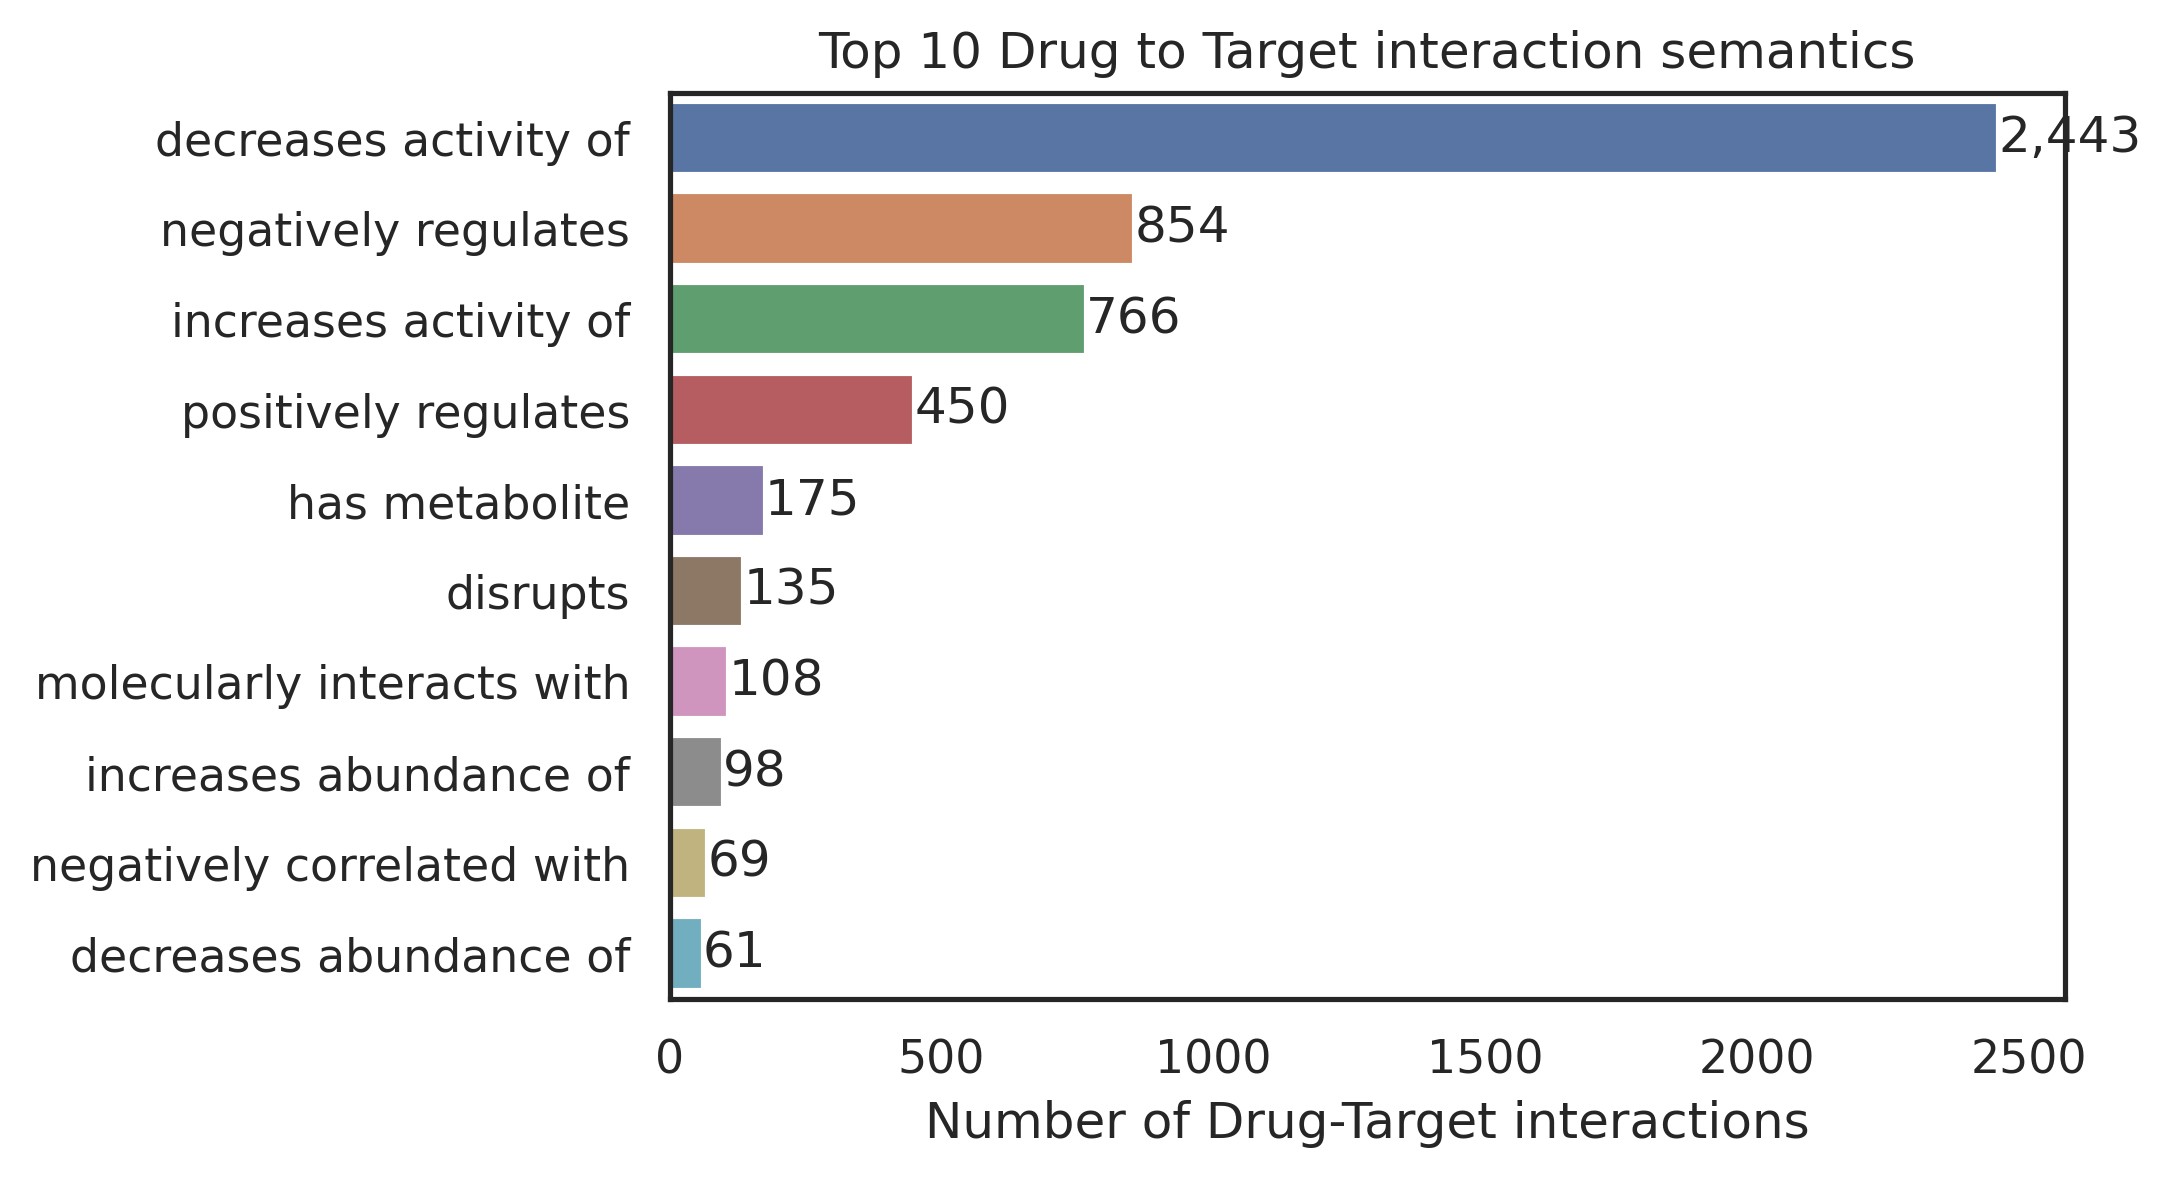

In [63]:
#Lets plot the interaction types connecting Drug-Target
count_plot_h(fet_data['interaction'].value_counts().head(10))
plt.title('Top 10 Drug to Target interaction semantics')
plt.xlabel('Number of Drug-Target interactions')
plt.ylabel('');

## Full Graph Analysis

In [64]:
for p in ind:
    G = path_to_G(p)

In [65]:
#Build graph 
Graph = nx.MultiDiGraph()

for p in ind:
    G = path_to_G(p)
    Graph = nx.compose(Graph, G)

In [66]:
print(nx.info(Graph))

Name: 
Type: MultiDiGraph
Number of nodes: 4947
Number of edges: 10342
Average in degree:   2.0906
Average out degree:   2.0906


In [67]:
nx.density(Graph)

0.00042267689755647633

In [68]:
sgraph = nx.MultiGraph(Graph)

In [69]:
components = list(nx.connected_components(sgraph))
len(components)

20

In [70]:
larget_component = max(components, key=len)

In [71]:
subgraph = sgraph.subgraph(larget_component)

In [73]:
nx.diameter(subgraph)

25

In [74]:
degree_dict = dict(Graph.degree(Graph.nodes))
nx.set_node_attributes(Graph, degree_dict, 'degree')
sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)

In [75]:
node_degree = pd.DataFrame(sorted_degree).rename(columns={0: 'id', 1: 'degree'})
node_degree['name'] = node_degree['id'].map(id_to_name)

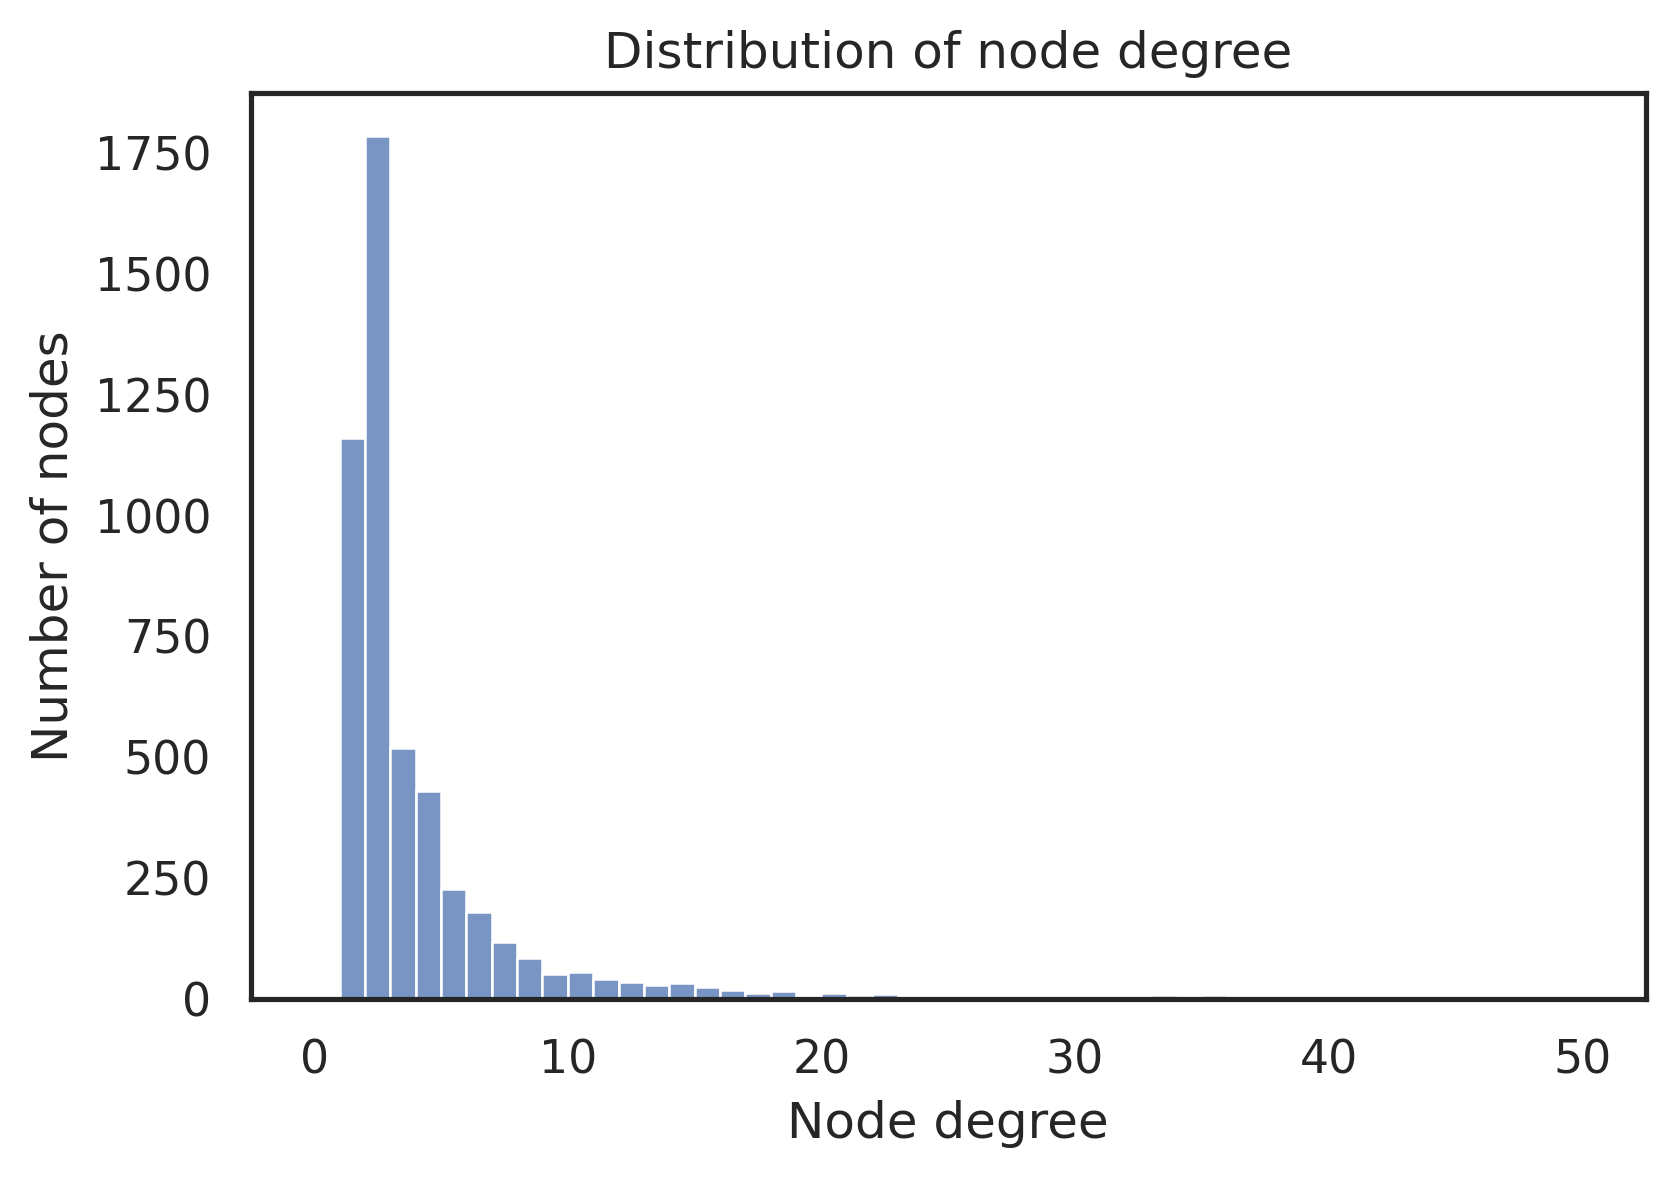

In [76]:
sns.histplot(node_degree['degree'],binwidth=1,binrange=[0,50])
plt.title('Distribution of node degree')
plt.xlabel('Node degree')
plt.ylabel('Number of nodes');

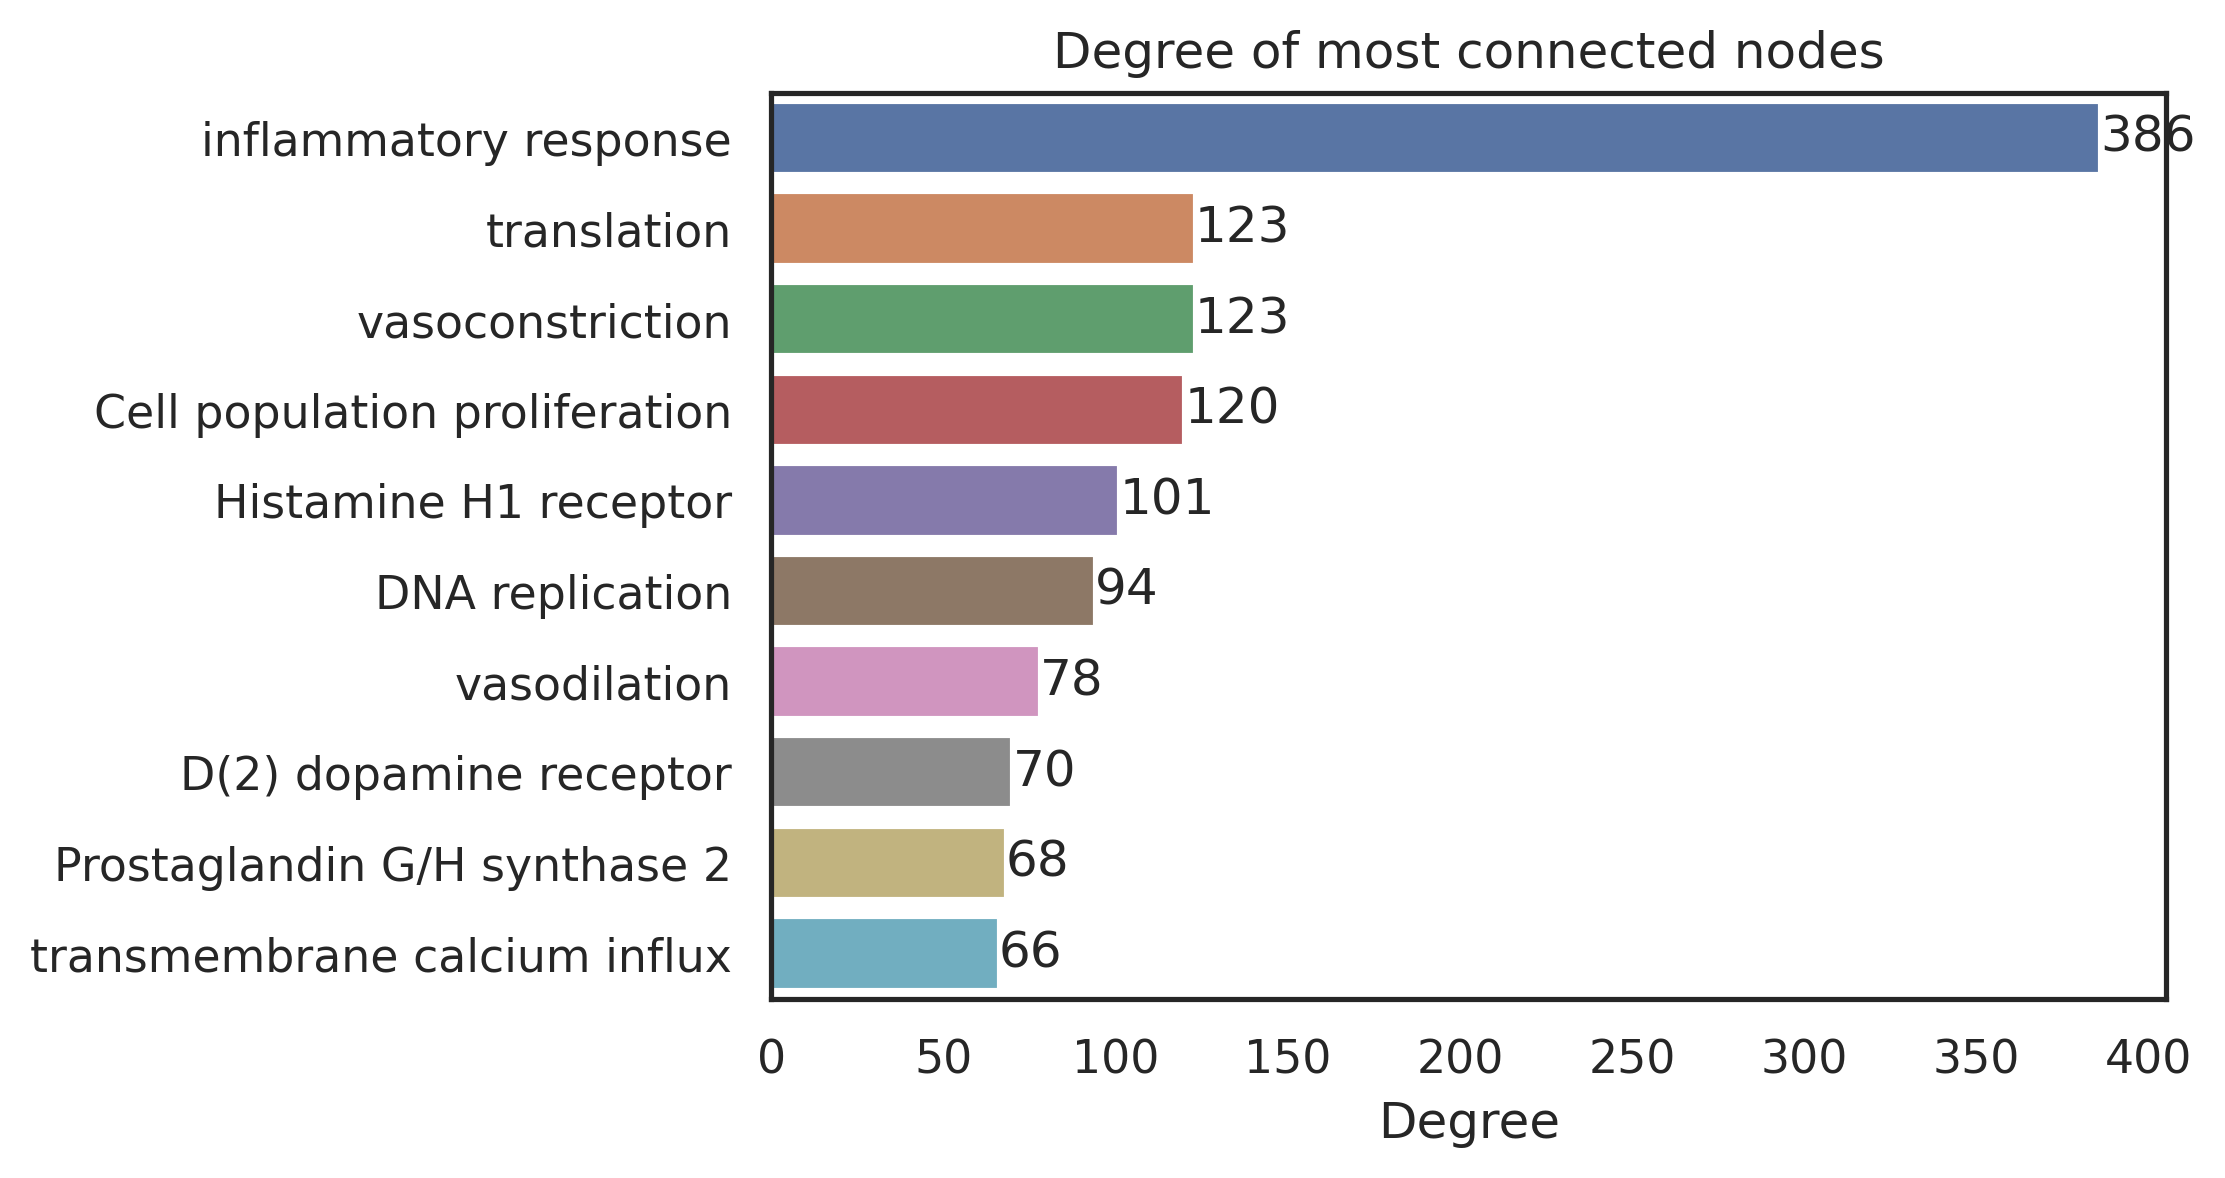

In [77]:
count_plot_h(node_degree.set_index('name')['degree'].head(10))
plt.title('Degree of most connected nodes');
plt.xlabel('Degree')
plt.ylabel('');

UsageError: Cell magic `%%jupyter` not found.
